In [1]:
from google.colab import drive
# Mount Google Cloud Drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Preprocess the text

In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

# Download nltk resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')  # used for part-of-speech tagging

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import string

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Load dataset
file_path = '/content/drive/MyDrive/ipen5810_miniproject1/reviews_bsample.csv'
reviews_data = pd.read_csv(file_path)

# Select text columns for analysis
text_columns = ['review_summary', 'review_pros', 'review_cons', 'review_advice']

# Convert all missing values to empty strings first, and ensure that all values are of string type
for col in text_columns:
    reviews_data[col] = reviews_data[col].fillna('').astype(str)

# Auxiliary function to convert NLTK part-of-speech tags to WordNet part-of-speech tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # participle
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Part-of-speech tagging
    tagged_tokens = pos_tag(tokens)
    # Word form restoration, considering part of speech
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_tokens]
    # Recombine into a string
    text = ' '.join(tokens)
    return text

# Apply text preprocessing to selected columns
for col in text_columns:
    reviews_data[col] = reviews_data[col].apply(preprocess_text)

# View processed data
print(reviews_data[text_columns].head())


                            review_summary  \
0                                      brc   
1                woman childrens residency   
2  fantastic company huge growth potential   
3                            great company   
4                                     good   

                                         review_pros  \
0  flexible work reputable organisation opportuni...   
1                great residency program depend unit   
2  great leadership well organize lot growth pote...   
3                 great company work 5 year everyday   
4                         10ph nice location trouble   

                            review_cons review_advice  
0   quite disorganised issue management                
1                     low pay high turn                
2  management high expectation easy job                
3            leave due personal problem                
4                            none night                


# 2. use NLP to classify the topic according to the employee_review & Visualize and interpret the topic classification results

The idea of field classification is as follows:


1. Determine the classification field (first make the combined field combined_review - combined review_summary, review_pros, review_cons, review_advice); then make three fields respectively, including review_pros, review_cons, review_advice);
2. Vectorize fields using TF-IDF method
3. Apply NMF topic model for classification
4. Apply to each sample and store the classification results of each field of each sample
4. Visualize classification results (word cloud visualization & topic distribution visualization)
5. Interpretation of results








## 2.1 Classification of combined text fields

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [5]:
# 1. Combine all text fields
reviews_data['combined_reviews'] = reviews_data[['review_summary', 'review_pros', 'review_cons', 'review_advice']].apply(lambda x: ' '.join(x), axis=1)

# 2. Using the TF-IDF method to vectorize the combined_reviews field
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(reviews_data['combined_reviews'])

# 3. Applying NMF Topic Model for Classification
nmf_model = NMF(n_components=5, random_state=42)  # N_components is the number of topics
nmf_topics = nmf_model.fit_transform(tfidf)

# Print themes and their keywords
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"Topic #{topic_idx+1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))
    print("\n")

# 4. Create a new column to store the topic classification results of each document
reviews_data['classify_combined_review'] = nmf_topics.argmax(axis=1)

# Print partial results
print(reviews_data[['combined_reviews', 'classify_combined_review']].head())


Topic #1:
work place balance life environment nice friendly best learn culture


Topic #2:
good salary benefit environment experience culture pay bad nice working


Topic #3:
pay management employee job hour people time staff manager make


Topic #4:
company culture work grow best employee growth opportunity small big


Topic #5:
great people benefit place team culture think experience opportunity atmosphere


                                    combined_reviews  classify_combined_review
0  brc flexible work reputable organisation oppor...                         2
1  woman childrens residency great residency prog...                         2
2  fantastic company huge growth potential great ...                         3
3  great company great company work 5 year everyd...                         3
4        good 10ph nice location trouble none night                          1


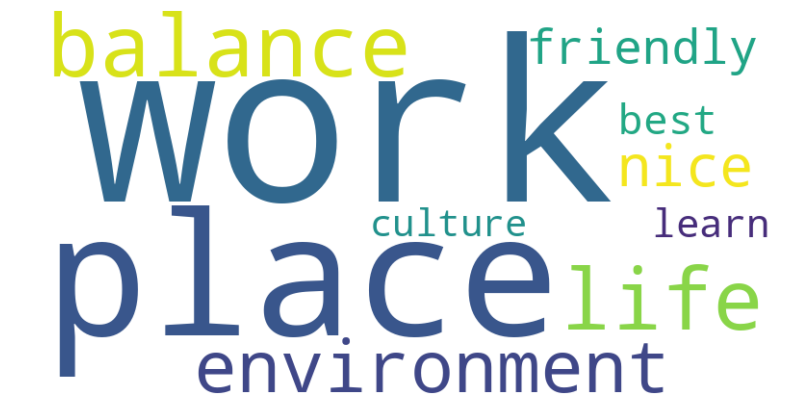

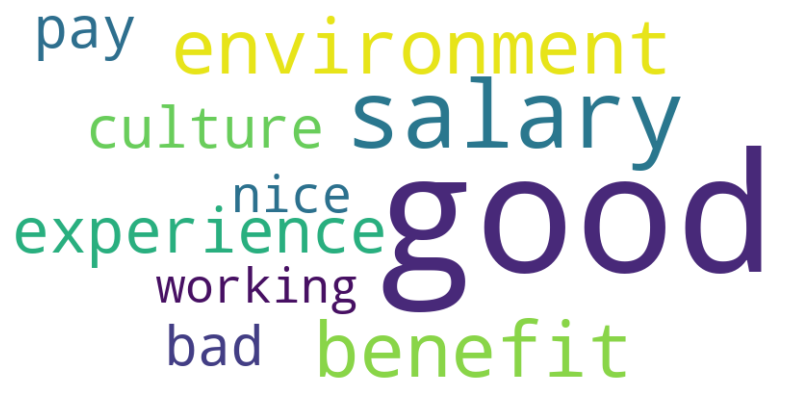

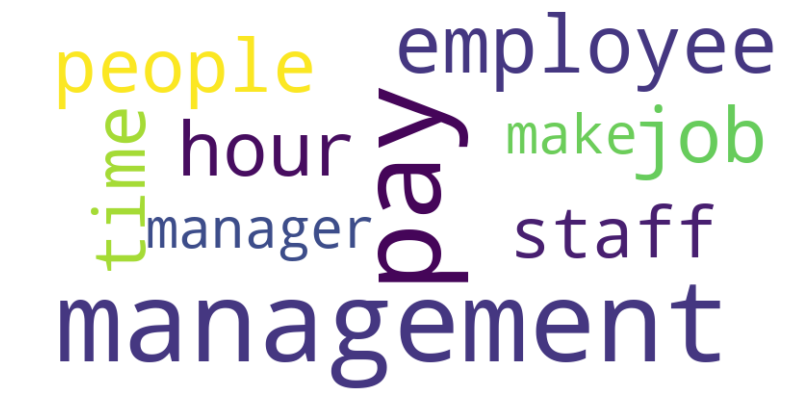

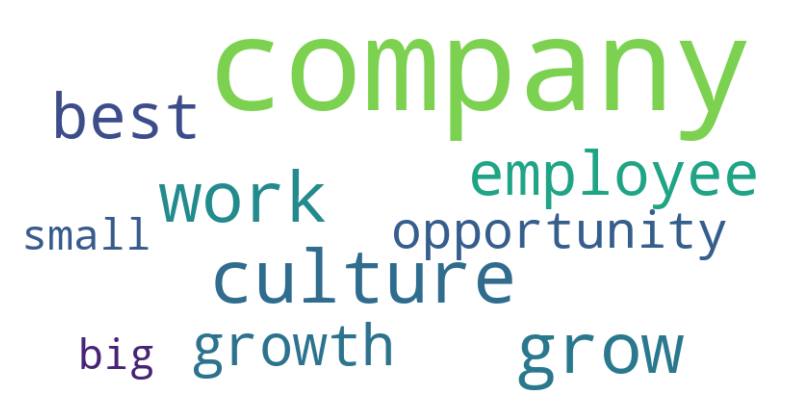

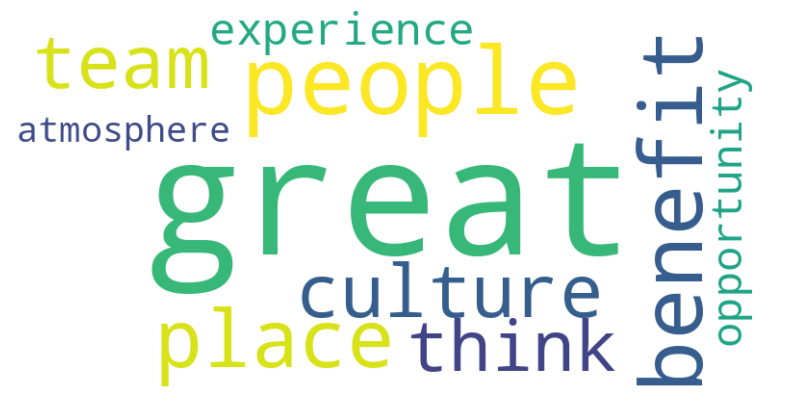

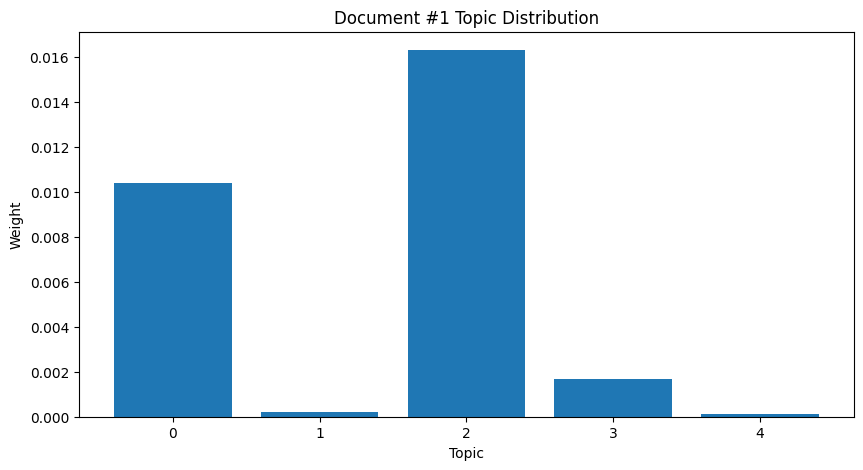

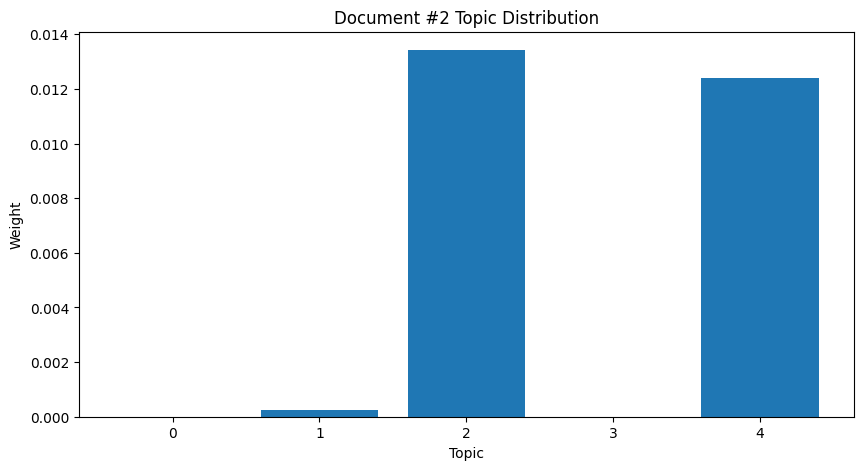

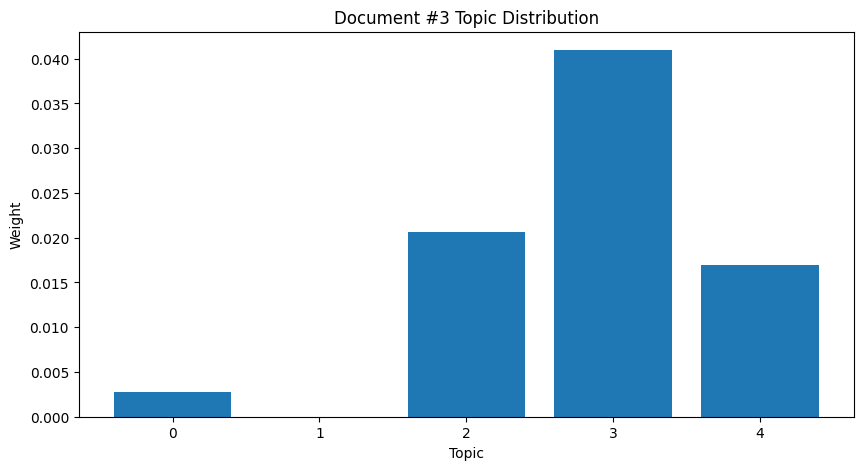

In [6]:
# 5. Visualize classification results
## 5.1. Word cloud visualization
for topic_idx, topic in enumerate(nmf_model.components_):
    # Generate word frequency dictionary
    freqs = {feature_names[i]: topic[i] for i in topic.argsort()[:-10 - 1:-1]}
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(freqs)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## 5.2. Visualization of topic distribution
# Select the first 3 documents to display
docs_indices = range(3)

for doc_index in docs_indices:
    plt.figure(figsize=(10, 5))
    plt.title(f"Document #{doc_index + 1} Topic Distribution")
    plt.bar(range(nmf_topics.shape[1]), nmf_topics[doc_index])
    plt.xlabel("Topic")
    plt.ylabel("Weight")
    plt.xticks(range(nmf_topics.shape[1]))
    plt.show()



##2.2 combined_review classification result analysis


1. Topic #1 - Work-Life Balance: Emphasizes the importance of balancing professional and personal life, fostering a positive and friendly work environment conducive to learning.
2. Topic #2 - Compensation and Benefits: Highlights the significance of fair compensation and benefits in enhancing employee satisfaction, despite occasional concerns about pay.
3. Topic #3 - Management and Hours: Focuses on the impact of management styles and working hours on employees' relationships and job satisfaction.
4. Topic #4 - Corporate Culture and Growth: Underlines the opportunities for personal and professional growth within the company culture, regardless of the company's size.
5. Topic #5 - Team and Opportunities: Stresses the value of teamwork and the positive atmosphere it creates, along with the importance of seizing growth and learning opportunities.

Conclusion:
The classification of combined_review topics offers insights into key employee concerns like work environment, compensation, management, and culture. This knowledge aids businesses in enhancing strengths and addressing weaknesses to foster positive development and career growth.

## 2.3 Classification of review_pros

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.corpus import stopwords

# 1. Vectorize the review_pros field using the TF-IDF method
tfidf_vectorizer_pros = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_pros = tfidf_vectorizer_pros.fit_transform(reviews_data['review_pros'])

# 2. Apply NMF topic model for classification
nmf_model_pros = NMF(n_components=5, random_state=42)
nmf_topics_pros = nmf_model_pros.fit_transform(tfidf_pros)

# Print topics and their keywords
feature_names_pros = tfidf_vectorizer_pros.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model_pros.components_):
    print(f"Topic #{topic_idx+1} (Review Pros):")
    print(" ".join([feature_names_pros[i] for i in topic.argsort()[:-10 - 1:-1]]))
    print("\n")


# 3. Create a new column to store the topic classification results of each document
reviews_data['classify_review_pros'] = nmf_topics_pros.argmax(axis=1)

# Print some results
print(reviews_data[['review_pros', 'classify_review_pros']].head())


Topic #1 (Review Pros):
work environment place friendly flexible fun hour schedule team best


Topic #2 (Review Pros):
good pay benefit company salary culture job management hour team


Topic #3 (Review Pros):
great company benefit team culture opportunity people pay employee management


Topic #4 (Review Pros):
people nice friendly office meet really smart lot help fun


Topic #5 (Review Pros):
balance life work worklife culture flexibility home project excellent good


                                         review_pros  classify_review_pros
0  flexible work reputable organisation opportuni...                     0
1                great residency program depend unit                     2
2  great leadership well organize lot growth pote...                     2
3                 great company work 5 year everyday                     2
4                         10ph nice location trouble                     3


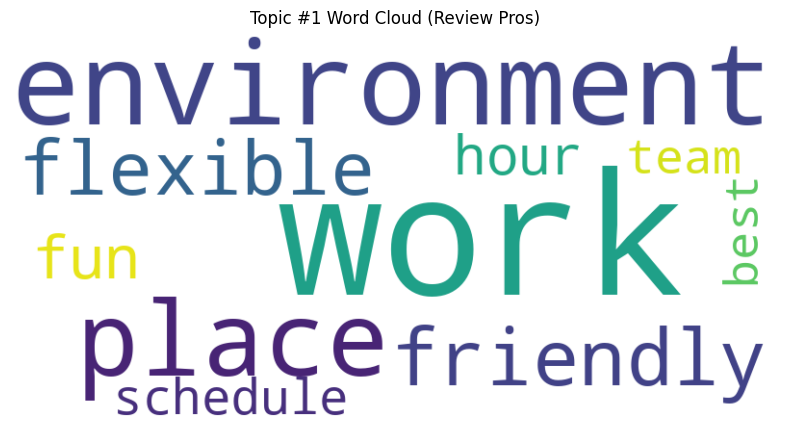

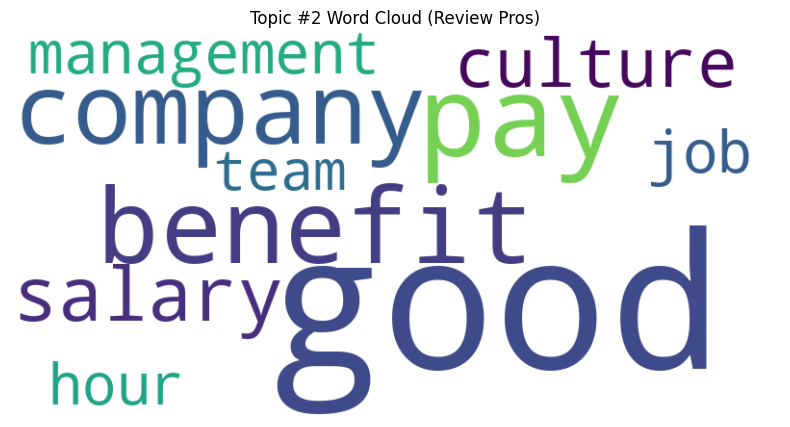

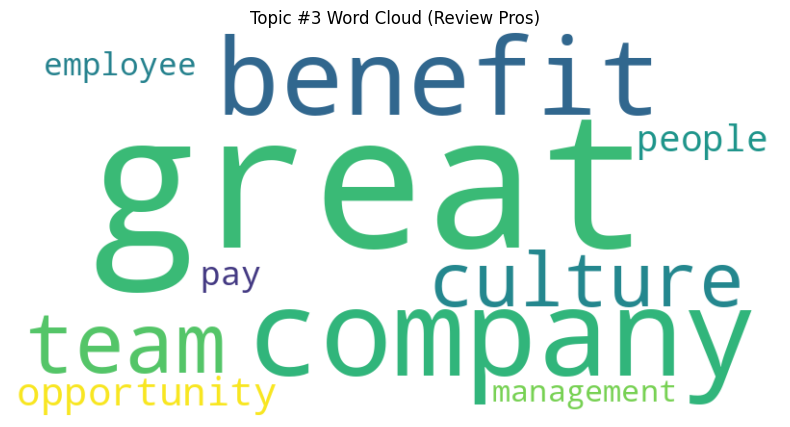

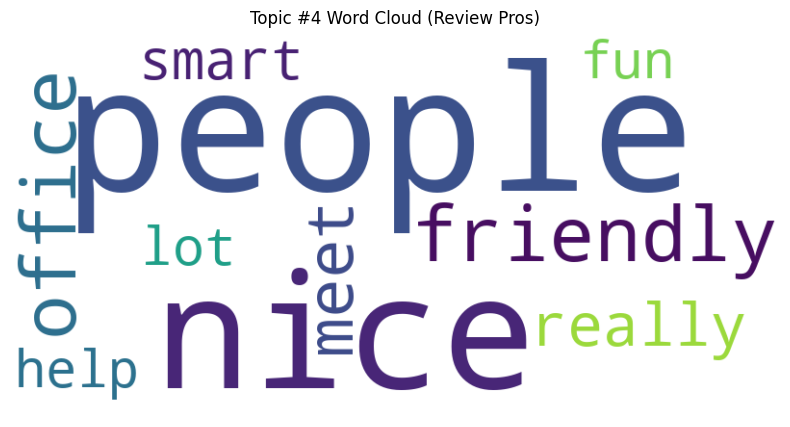

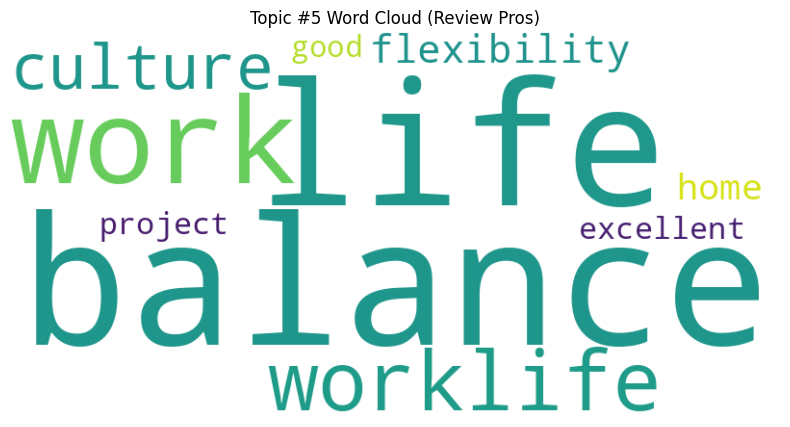

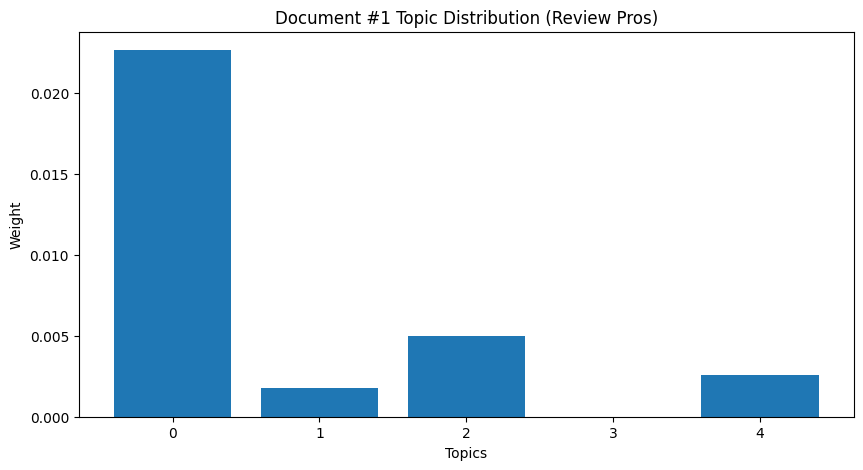

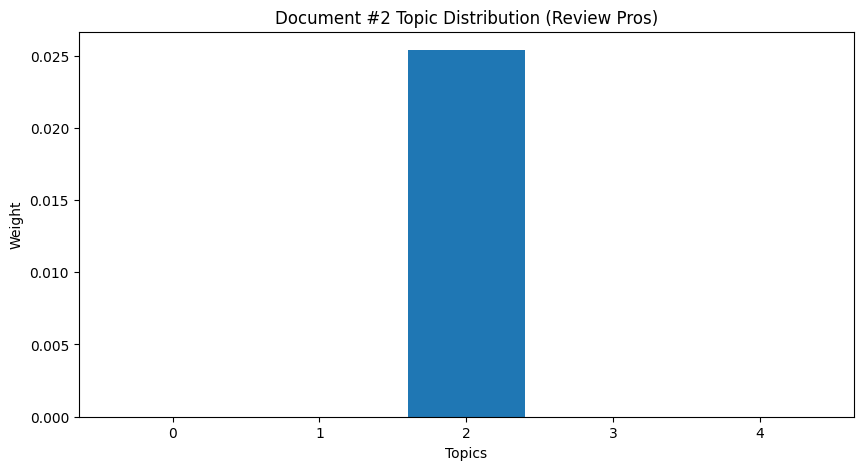

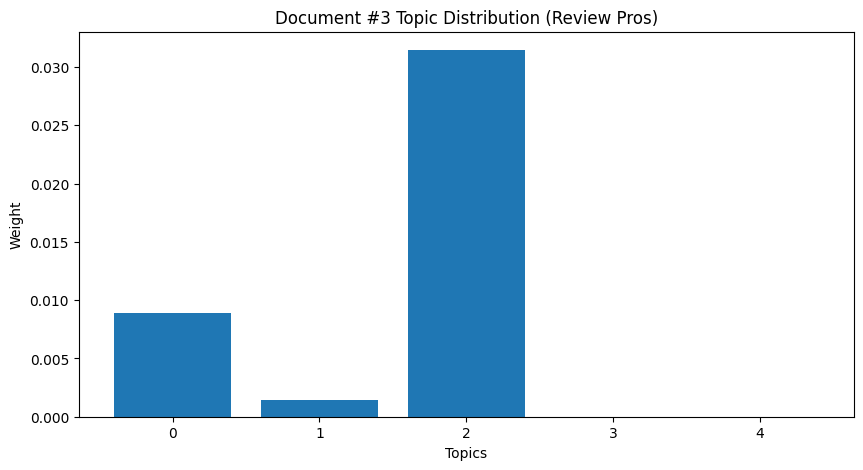

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 5. Visualize classification results
## 5.1. Word cloud visualization
for topic_idx, topic in enumerate(nmf_model_pros.components_):
    # Generate word frequency dictionary
    freqs = {feature_names_pros[i]: topic[i] for i in topic.argsort()[:-10 - 1:-1]}
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(freqs)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic #{topic_idx+1} Word Cloud (Review Pros)")
    plt.show()


## 5.2. Visualization of topic distribution
# Select the first 3 documents to display
docs_indices = range(3)

for doc_index in docs_indices:
    plt.figure(figsize=(10, 5))
    plt.title(f"Document #{doc_index + 1} Topic Distribution (Review Pros)")
    plt.bar(range(nmf_topics_pros.shape[1]), nmf_topics_pros[doc_index])
    plt.xlabel("Topics")
    plt.ylabel("Weight")
    plt.xticks(range(nmf_topics_pros.shape[1]))
    plt.show()



## 2.4 Interpretation of the results of review_pros


1.   Topic #1 - Positive Work Environment: Emphasizes a supportive atmosphere with friendly, flexible hours, and team collaboration. "Fun" suggests a pleasant vibe, and "best" indicates high employee regard for their workplace.
2.   Topic #2 - Compensation and Benefits: Focuses on pay, benefits, and company culture, highlighting the impact of good compensation on employee satisfaction. Mentions of "management" and "team" suggest leadership style and team spirit are seen as company strengths.
3.   Topic #3 - Company Strengths and Opportunities: Highlights company benefits, team culture, and career growth opportunities. "Great" and "opportunity" point to paths for advancement, while "people" and "employee" stress positive relationships among staff.
4.   Topic #4 - Social and Interpersonal Relations: Concentrates on workplace social aspects and interpersonal relations, featuring friendly colleagues and a helpful environment. "Smart" might indicate appreciation for colleagues' talents and skills.
5.   Topic #5 - Work-Life Balance: Focuses on balancing work with personal life, underlining flexible work arrangements and a supportive company culture. "Excellent" and "good" show positive employee feedback on this aspect.

Conclusion:
These themes highlight employees' values: supportive work culture, fair pay, growth opportunities, interpersonal relationships, and work-life balance. This insight helps companies focus on areas critical for enhancing employee satisfaction and retention.

## 2.5 Classification of review_cons

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.corpus import stopwords

# 1. Vectorize the review_cons field using the TF-IDF method
tfidf_vectorizer_cons = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_cons = tfidf_vectorizer_cons.fit_transform(reviews_data['review_cons'])

# 2. Apply NMF topic model for classification
nmf_model_cons = NMF(n_components=5, random_state=42)
nmf_topics_cons = nmf_model_cons.fit_transform(tfidf_cons)

# Print topics and their keywords
feature_names_cons = tfidf_vectorizer_cons.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model_cons.components_):
    print(f"Topic #{topic_idx+1} (Review Cons):")
    print(" ".join([feature_names_cons[i] for i in topic.argsort()[:-10 - 1:-1]]))
    print("\n")

# 3. Create a new column to store the topic classification results of each document
reviews_data['classify_review_cons'] = nmf_topics_cons.argmax(axis=1)

# Print some results
print(reviews_data[['review_cons', 'classify_review_cons']].head())


Topic #1 (Review Cons):
work balance life place hard lot environment great people pressure


Topic #2 (Review Cons):
think really moment canã dont right honestly negative great say


Topic #3 (Review Cons):
pay company low management good salary bad employee poor benefit


Topic #4 (Review Cons):
hour long day pay working shift week weekend stressful expect


Topic #5 (Review Cons):
time busy lot job stressful dont change difficult little slow


                            review_cons  classify_review_cons
0   quite disorganised issue management                     2
1                     low pay high turn                     2
2  management high expectation easy job                     2
3            leave due personal problem                     2
4                            none night                     3


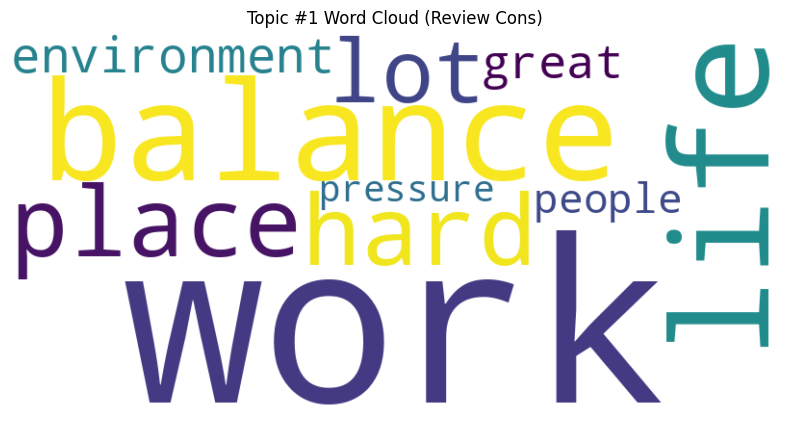

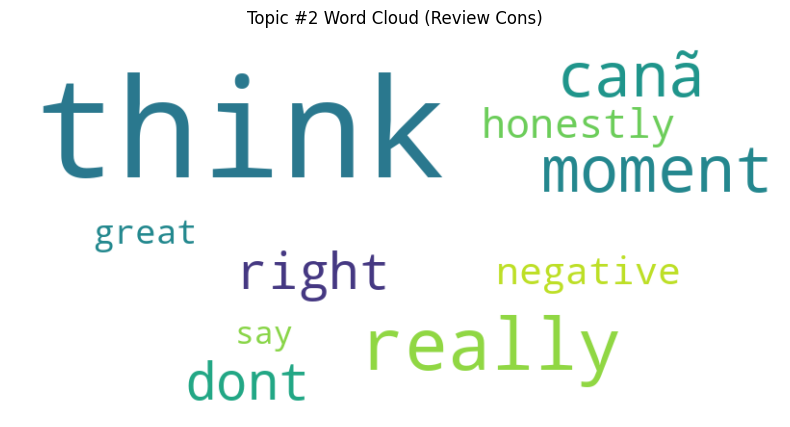

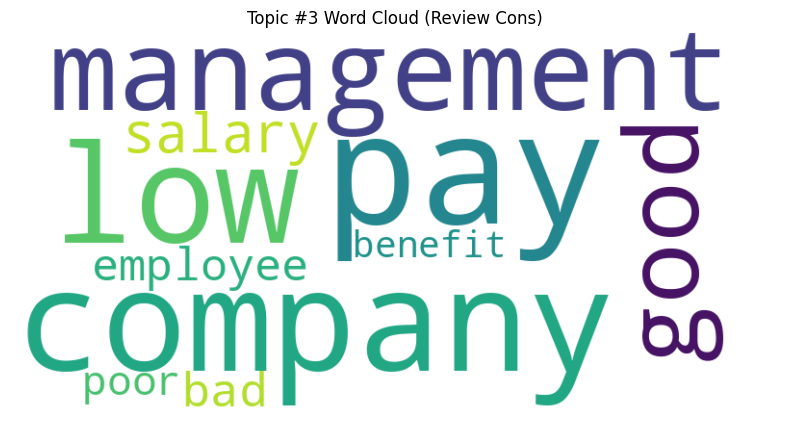

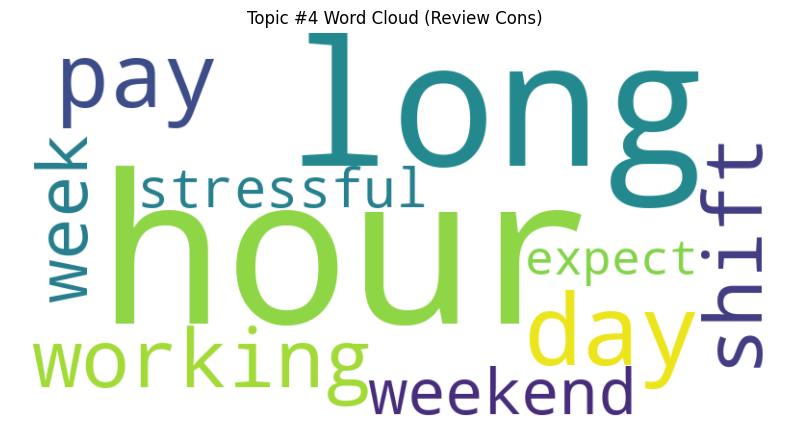

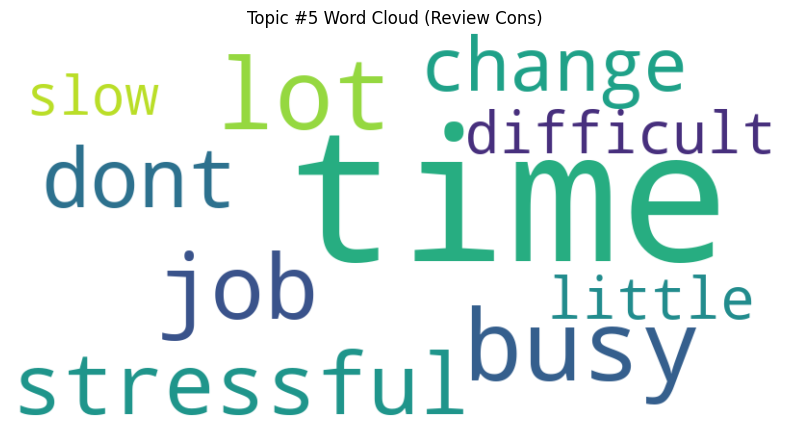

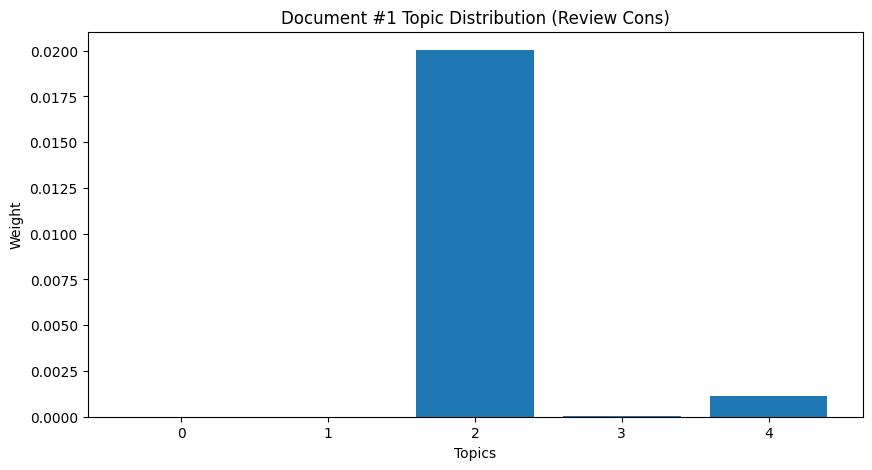

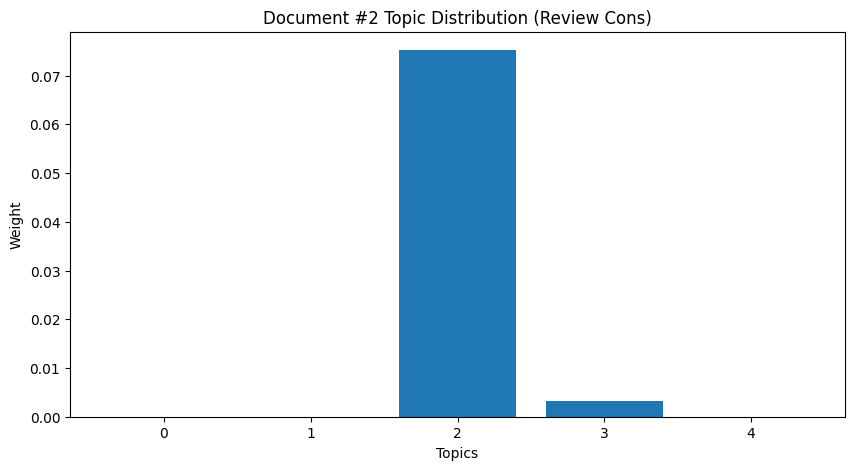

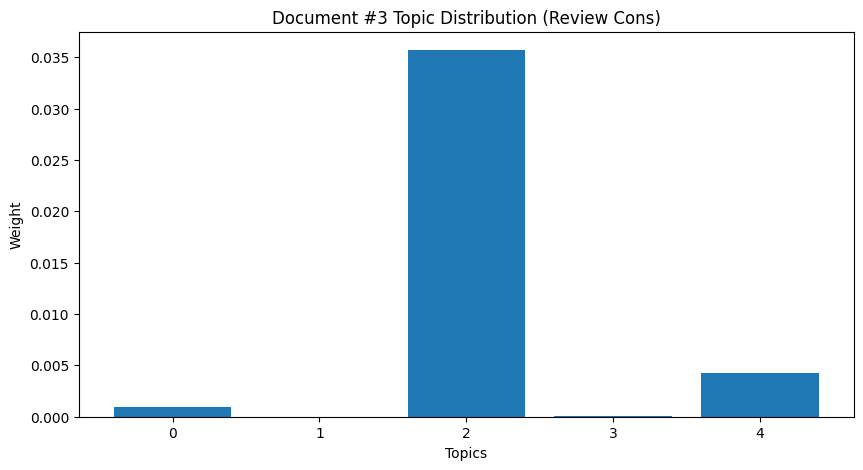

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 5. Visualize classification results
## 5.1. Word cloud visualization
for topic_idx, topic in enumerate(nmf_model_cons.components_):
    # Generate word frequency dictionary
    freqs = {feature_names_cons[i]: topic[i] for i in topic.argsort()[:-10 - 1:-1]}
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(freqs)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic #{topic_idx+1} Word Cloud (Review Cons)")
    plt.show()

## 5.2. Visualization of topic distribution
# Select the first 3 documents to display
docs_indices = range(3)

for doc_index in docs_indices:
    plt.figure(figsize=(10, 5))
    plt.title(f"Document #{doc_index + 1} Topic Distribution (Review Cons)")
    plt.bar(range(nmf_topics_cons.shape[1]), nmf_topics_cons[doc_index])
    plt.xlabel("Topics")
    plt.ylabel("Weight")
    plt.xticks(range(nmf_topics_cons.shape[1]))
    plt.show()


## 2.6 Interpretation of the results of review_cons



1.   Topic #1 - Work-Life Balance & Stress: Highlights the struggle with work-life balance and workplace stress, noting both positive coworker relations and significant concerns about pressure.
2.   Topic #2 - Reflections & Feelings: Captures employees' mixed feelings about their work environment, indicating both positive aspects and potential emotional conflicts.
3.   Topic #3 - Compensation & Management: Focuses on dissatisfaction with pay, benefits, and management quality, pointing to these as main areas of employee discontent.
4.   Topic #4 - Working Hours & Expectations: Discusses issues with long working hours and unrealistic expectations, underlining their contribution to stress.
5.   Topic #5 - Busyness & Challenges: Concentrates on the demanding and difficult nature of work, suggesting frustration with the pace or progress of work.


Conclusion：
These themes reveal key aspects of employee dissatisfaction, including work-life balance, compensation, and workload, providing essential insights for improving workplace satisfaction and conditions.




The analysis of pros and cons themes reveals that positive feedback focuses on the work environment, compensation, culture, relationships, and work-life balance. In contrast, negatives highlight challenges in balance, personal feelings, pay and management issues, working hours, and stress. This offers crucial insights for businesses to understand what drives employee satisfaction and areas for improvement.


## 2.7 Classification of review_advice

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.corpus import stopwords

# 1. Vectorize the review_advice field using the TF-IDF method
tfidf_vectorizer_advice = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_advice = tfidf_vectorizer_advice.fit_transform(reviews_data['review_advice'])

# 2. Apply NMF topic model for classification
nmf_model_advice = NMF(n_components=5, random_state=42)
nmf_topics_advice = nmf_model_advice.fit_transform(tfidf_advice)

# Print topics and their keywords
feature_names_advice = tfidf_vectorizer_advice.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model_advice.components_):
    print(f"Topic #{topic_idx+1} (Review Advice):")
    print(" ".join([feature_names_advice[i] for i in topic.argsort()[:-10 - 1:-1]]))
    print("\n")

# 3. Create a new column to store the topic classification results of each document
reviews_data['classify_review_advice'] = nmf_topics_advice.argmax(axis=1)

# Print some results
print(reviews_data[['review_advice', 'classify_review_advice']].head())


Topic #1 (Review Advice):
good work communication job luck manager salary thing lose retain


Topic #2 (Review Advice):
employee listen care treat respect value continue pay make company


Topic #3 (Review Advice):
work great hard place life environment balance continue company culture


Topic #4 (Review Advice):
people staff pay hire company make dont need stop manager


Topic #5 (Review Advice):
management advice need new team upper change training great time


  review_advice  classify_review_advice
0                                     0
1                                     0
2                                     0
3                                     0
4                                     0


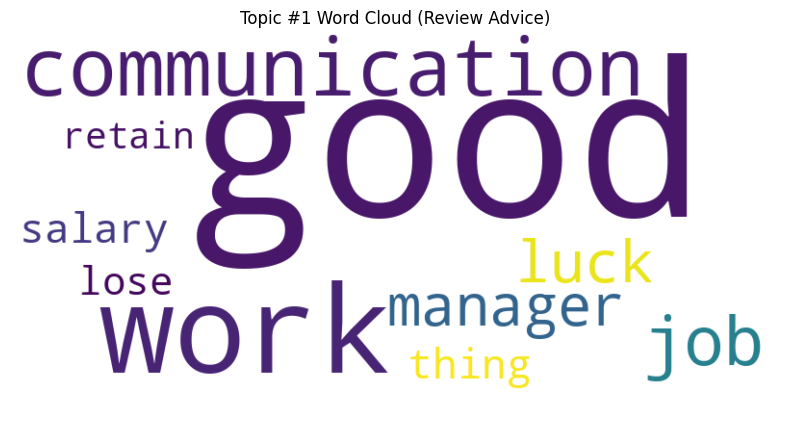

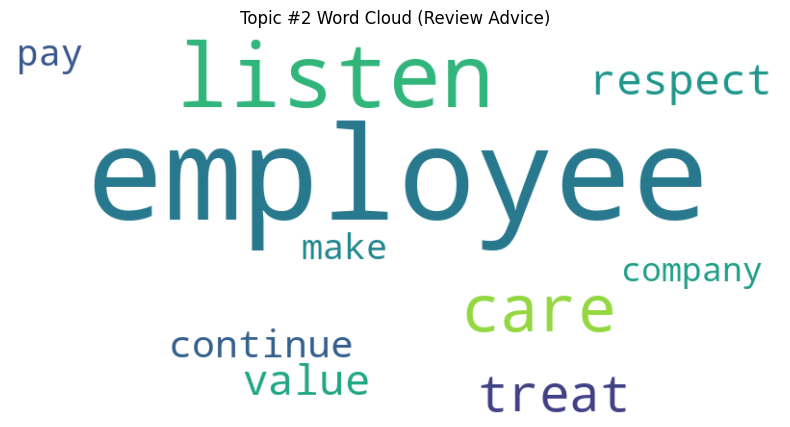

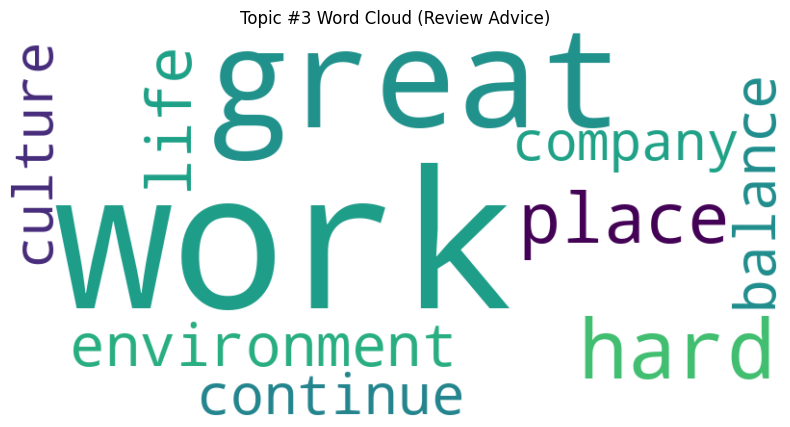

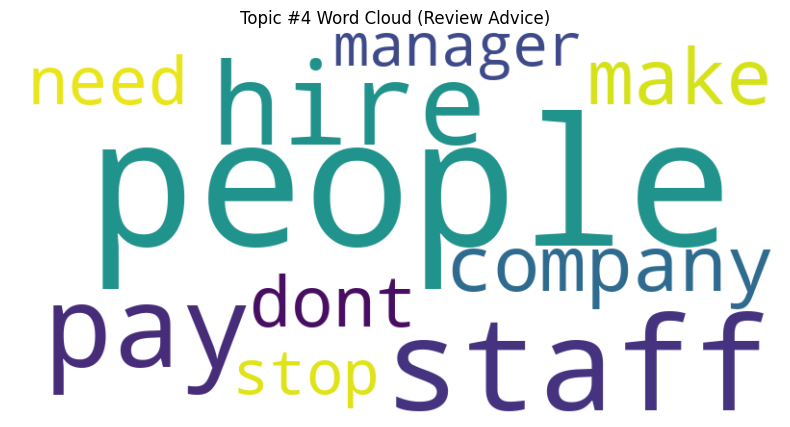

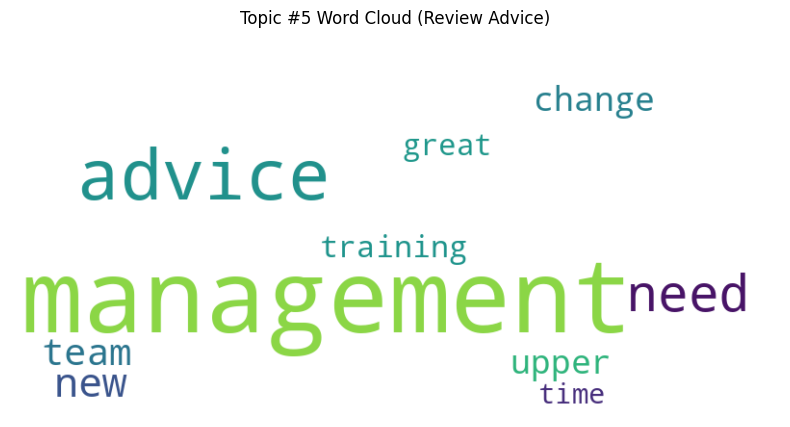

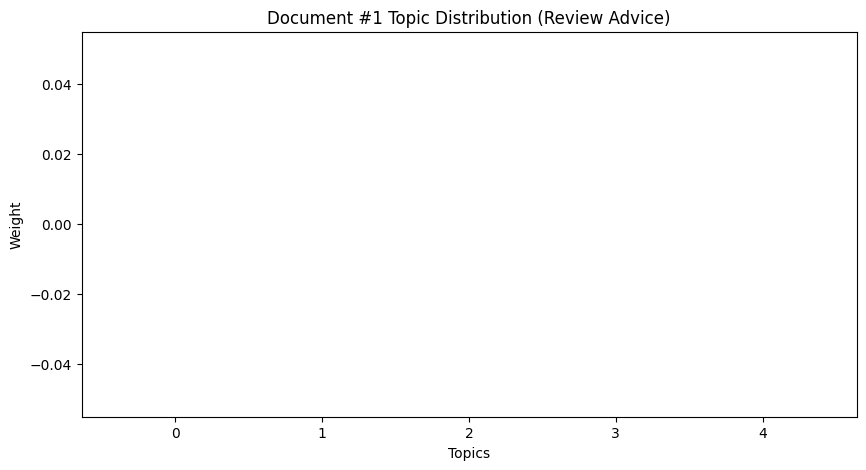

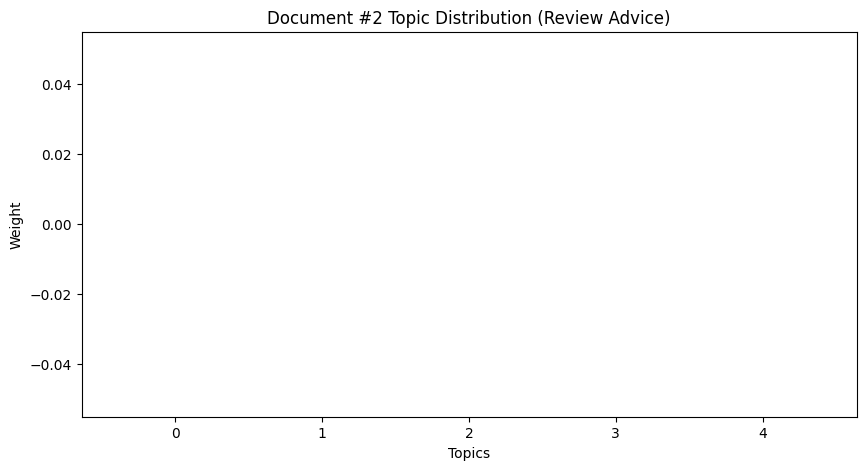

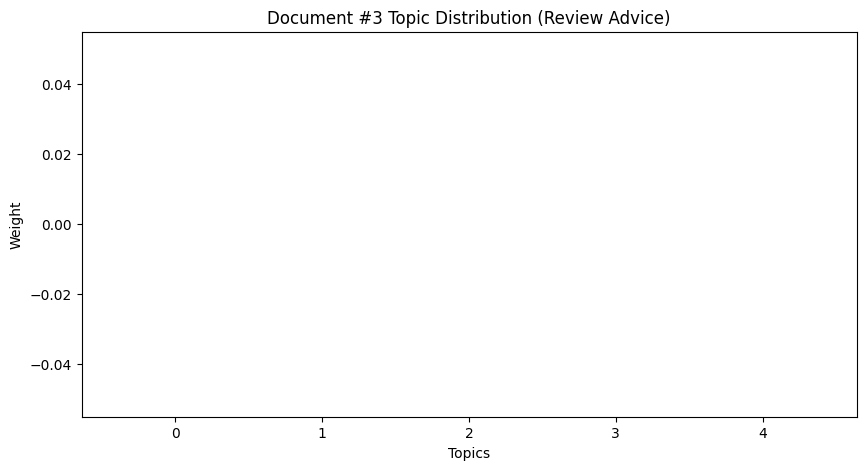

In [12]:
# 5. Visualize classification results
## 5.1. Word cloud visualization
for topic_idx, topic in enumerate(nmf_model_advice.components_):
    # Generate word frequency dictionary
    freqs = {feature_names_advice[i]: topic[i] for i in topic.argsort()[:-10 - 1:-1]}
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(freqs)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic #{topic_idx+1} Word Cloud (Review Advice)")
    plt.show()

## 5.2. Visualization of topic distribution
# Select the first 3 documents to display
docs_indices = range(3)

for doc_index in docs_indices:
    plt.figure(figsize=(10, 5))
    plt.title(f"Document #{doc_index + 1} Topic Distribution (Review Advice)")
    plt.bar(range(nmf_topics_advice.shape[1]), nmf_topics_advice[doc_index])
    plt.xlabel("Topics")
    plt.ylabel("Weight")
    plt.xticks(range(nmf_topics_advice.shape[1]))
    plt.show()


## 2.8 Interpretation of the results of review_advice



1.   Topic #1 - Work Attitude & Environment: Suggestions target work attitude, emphasizing good communication, hard work, and life balance. Advises continuous effort and management/environment improvement.
2.   Topic #2 - Employee Respect & Care: Highlights the need for businesses to listen, care, and respect employees, valuing their feedback. Recommends trust-building and better treatment.
3.   Topic #3 - Positive Workplace Maintenance: Discusses maintaining a positive culture and environment, encouraging teamwork. Shows the necessity of preserving a good work culture.
4.   Topic #4 - Compensation, Hiring & Management: Talks about fairness in pay, recruitment strategies, and management practices. Suggests focusing on fair treatment, reasonable hiring, and management improvement.
5.   Topic #5 - Management & Development Suggestions: Offers advice on management and team development, stressing new perspectives, more training, and time for change and reflection.


Conclusion：
The analysis of review_advice highlights employee desires for improved treatment, communication, work culture, compensation policies, and leadership development, offering key insights for enhancing satisfaction and performance.

## 2.9 Result storage

In [13]:
print(reviews_data)

          rcid  company_id                             company  review_id  \
0        75775       36982       The British Red Cross Society   63094119   
1      6831823      618643   TriStar Centennial Medical Center   65255882   
2       724484     7036445                    Odd Burger Corp.   61700338   
3       809141        7927                        Infosys Ltd.    9589496   
4       883558     1886918                    T3 Security Ltd.   16603650   
...        ...         ...                                 ...        ...   
66099  1213310       14086                    Therma-Tru Corp.    8059037   
66100  1183299      596230                   Xiamen University   55524512   
66101   405288     1441029  Guildford Borough Council (405288)   35943616   
66102  1393437        1089                     Adecco Group AG   41173814   
66103  4288915      423878                       Intratek Inc.    9635269   

      review_language_id        location_raw           region         count

In [14]:
reviews_data.to_csv('/content/drive/MyDrive/ipen5810_miniproject1/processed0_reviews_data.csv', index=False)

# 3.  utilizing GPT to improve the accuracy and depth of topic detection

## 3.1 零样本学习（Zero-shot Learning）：
GPT supports zero-shot learning, which is classifying text or identifying topics without explicit labels.
More flexible topic detection can be achieved by defining a set of topic descriptions and letting GPT predict which topic description a given text best matches.

Based on the results of the previous NMF classification model, zero-shot learning is used for combined_review, review_pros, review_cons, and reiview_advice fields respectively.

In [15]:
# 1. Zero-shot learning is used to identify the type of review_pros field
from transformers import pipeline

# Load the zero-shot classifier, using the `transformers` library from Hugging Face
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define the topic descriptions in English
topic_descriptions_pros = [
    "Positive and friendly work environment with flexible hours and strong team dynamics",
    "Good compensation including pay and benefits, with a supportive company culture",
    "Great company with beneficial opportunities, a strong team, and supportive management",
    "Friendly and supportive colleagues in a welcoming office environment",
    "Strong emphasis on work-life balance and flexibility, with a focus on project excellence"
]

#Initialize counter
count = 0
#Set the number of printed values
num_to_print = 5

# Classify each text in the DataFrame
for pros in reviews_data['review_pros']:
    if count < num_to_print:
        # Use the zero-shot classifier to predict
        result = classifier(pros, topic_descriptions_pros)

        # Print the most likely topic
        print(f"Text: {pros}")
        print("Predicted topic:", result["labels"][0])  # The most matching topic
        print("----------")

        # Update counter
        count += 1
    else:
        # Reaching the required quantity, exiting the loop
        break


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Text: flexible work reputable organisation opportunity development
Predicted topic: Great company with beneficial opportunities, a strong team, and supportive management
----------
Text: great residency program depend unit
Predicted topic: Positive and friendly work environment with flexible hours and strong team dynamics
----------
Text: great leadership well organize lot growth potential exciting emerge brand thats go place also love company mission
Predicted topic: Great company with beneficial opportunities, a strong team, and supportive management
----------
Text: great company work 5 year everyday
Predicted topic: Positive and friendly work environment with flexible hours and strong team dynamics
----------
Text: 10ph nice location trouble
Predicted topic: Great company with beneficial opportunities, a strong team, and supportive management
----------


In [16]:
# 2. Zero-shot learning is used to identify the type of review_cons field
from transformers import pipeline

# Load the zero-shot classifier, using the `transformers` library from Hugging Face
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define the topic descriptions in English
topic_descriptions_cons = [
    "Work-life balance challenges with a high-pressure environment",
    "Moments of negativity and uncertainty, with a need for honest reflection",
    "Issues with low pay, poor management, and insufficient benefits",
    "Long hours, including demanding shifts and weekends, leading to stress",
    "Highly busy times leading to job stress, with slow changes and difficult tasks"
]

#Initialize counter
count = 0
#Set the number of printed values
num_to_print = 3

# Classify each text in the DataFrame
for cons in reviews_data['review_cons']:
    if count < num_to_print:
        # Use the zero-shot classifier to predict
        result = classifier(cons, topic_descriptions_cons)

        # Print the most likely topic
        print(f"Text: {cons}")
        print("Predicted topic:", result["labels"][0])  # The most matching topic
        print("----------")

        # Update counter
        count += 1
    else:
        # Reaching the required quantity, exiting the loop
        break


Text: quite disorganised issue management
Predicted topic: Moments of negativity and uncertainty, with a need for honest reflection
----------
Text: low pay high turn
Predicted topic: Moments of negativity and uncertainty, with a need for honest reflection
----------
Text: management high expectation easy job
Predicted topic: Work-life balance challenges with a high-pressure environment
----------


In [17]:
# 3. Zero-shot learning is used to identify the type of review_advice field
from transformers import pipeline

# Load the zero-shot classifier, using the `transformers` library from Hugging Face
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define the topic descriptions in English
topic_descriptions_advice = [
    "Good work communication and life balance",
    "Employee respect and value",
    "Great work environment and team culture",
    "Staff compensation and management",
    "Management advice and improvement"
]

#Initialize counter
count = 0
#Set the number of printed values
num_to_print = 3

# Classify each text in the DataFrame
for advice in reviews_data['review_advice']:
    # Ensure that advice is not an empty string
    if advice and count < num_to_print:
        # Use the zero-shot classifier to predict
        result = classifier(advice, topic_descriptions_advice)

        # Print the most likely topic
        print(f"Text: {advice}")
        print("Predicted topic:", result["labels"][0])  # The most matching topic
        print("----------")

        # Update counter
        count += 1
    else:
        # If the advice is an empty string, skip this sample
        continue

    if count >= num_to_print:
        # Reaching the required quantity, exiting the loop
        break


Text: matter dont listen long upper management make money continue cut job cost good
Predicted topic: Management advice and improvement
----------
Text: improve surgery schedule reduce burn staff
Predicted topic: Management advice and improvement
----------
Text: office time want get task do time
Predicted topic: Management advice and improvement
----------


In [18]:
# 4. Zero-shot learning is used to identify the type of combined_reviews field
from transformers import pipeline

# Load the zero-shot classifier, using the `transformers` library from Hugging Face
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define the topic descriptions in English
topic_descriptions_combined = [
    "Work-life balance and a friendly environment conducive to learning and cultural growth",
    "Compensation and cultural experience, encompassing both positive and negative aspects of salary, benefits, and working conditions",
    "Employee and management dynamics, focusing on pay, job satisfaction, and the impacts of management on staff",
    "Company culture and opportunities for growth, highlighting both small and large company environments",
    "Great team atmosphere with beneficial opportunities, fostering a positive culture and work experience"
]

#Initialize counter
count = 0
#Set the number of printed values
num_to_print = 3

# Classify each text in the DataFrame
for combined in reviews_data['combined_reviews']:
    if count < num_to_print:
        # Use the zero-shot classifier to predict
        result = classifier(combined, topic_descriptions_combined)

        # Print the most likely topic
        print(f"Text: {combined}")
        print("Predicted topic:", result["labels"][0])  # The most matching topic
        print("----------")

        # Update counter
        count += 1
    else:
        # Reaching the required quantity, exiting the loop
        break


Text: brc flexible work reputable organisation opportunity development quite disorganised issue management 
Predicted topic: Work-life balance and a friendly environment conducive to learning and cultural growth
----------
Text: woman childrens residency great residency program depend unit low pay high turn 
Predicted topic: Compensation and cultural experience, encompassing both positive and negative aspects of salary, benefits, and working conditions
----------
Text: fantastic company huge growth potential great leadership well organize lot growth potential exciting emerge brand thats go place also love company mission management high expectation easy job 
Predicted topic: Great team atmosphere with beneficial opportunities, fostering a positive culture and work experience
----------


## 3.2 Using GPT for data enhancement

### 3.2.1 Take the review_advice field as an example (because it has relatively few samples)

In [20]:
import random
from transformers import pipeline, set_seed
from tqdm.auto import tqdm  # 使用tqdm的自动选择接口，以便在不同环境中获得最佳的进度条显示

# 假设 reviews_data 已经定义且包含 'review_advice' 列

random.seed(42)

# Randomly select samples that do not contain empty strings
sample_texts = reviews_data['review_advice'][reviews_data['review_advice'] != ''].sample(200).tolist()

#Print the selected sample text
for i, text in enumerate(sample_texts):
    print(f"Sample {i+1}: {text}")

# Initialize text generation pipeline, using GPT-2
generator = pipeline('text-generation', model='gpt2')
set_seed(42)  # Set random seed

generated_texts = []

# Use tqdm to create a progress bar for the loop
for text in tqdm(sample_texts, desc="Generating text"):
    generated = generator(text, max_new_tokens=200, num_return_sequences=1)
    generated_texts.append(generated[0]['generated_text'])

print("Generation completed.")


Sample 1: one thing would like say vss open another office gurgaon high opportunity sap consult business
Sample 2: talk worker
Sample 3: keep contact temporary team regularly available career progression
Sample 4: im align overall product vision strategy however execution need much quicker remain competitive consumer marketing strategy need review young people especially outside u dont even know dbx benefit
Sample 5: hour flexibility
Sample 6: staff
Sample 7: keep
Sample 8: value employee theres lot talk value respect many case truth different story
Sample 9: responsive
Sample 10: treat everyone humane
Sample 11: keep contentful culture alive micromanagement doesnt work
Sample 12: survey manager staff experience everyone important donã¢âât let bamboozle
Sample 13: well
Sample 14: separate department soon possible late
Sample 15: continue develop employee future leader
Sample 16: need treat staff respect listen try assist answer query
Sample 17: continue nyc training camp new designer

Generating text:   0%|          | 0/200 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Generation completed.


In [21]:
#Step 2: Merge original text and new text

# Add the generated new text to the original review_advice column
augmented_reviews = reviews_data['review_advice'].tolist() + generated_texts

# If you need to convert the merged data back to DataFrame for processing
augmented_reviews_df = pd.DataFrame(augmented_reviews, columns=['review_advice'])


Topic #1 (Review Advice):
good work communication job luck manager thing salary lose retain


Topic #2 (Review Advice):
employee listen care treat respect value continue pay make company


Topic #3 (Review Advice):
work great hard place life environment balance continue culture team


Topic #4 (Review Advice):
people staff pay hire company make dont need manager stop


Topic #5 (Review Advice):
management advice need new team upper change training great time




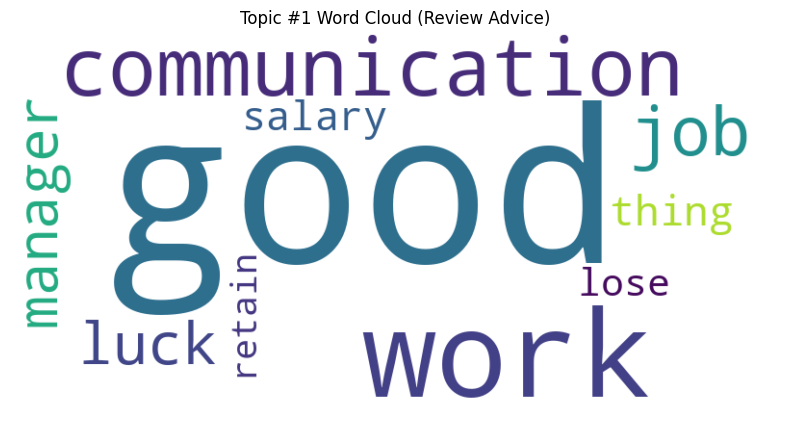

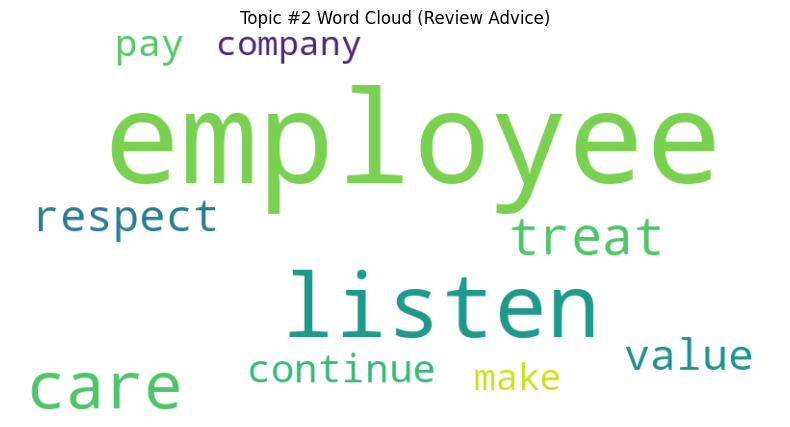

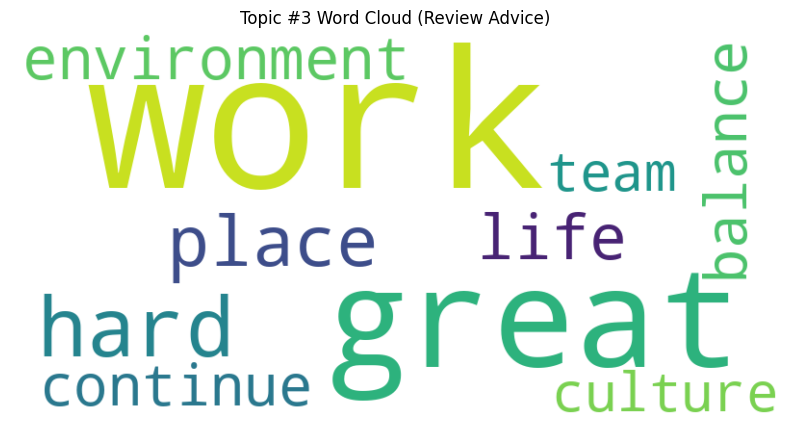

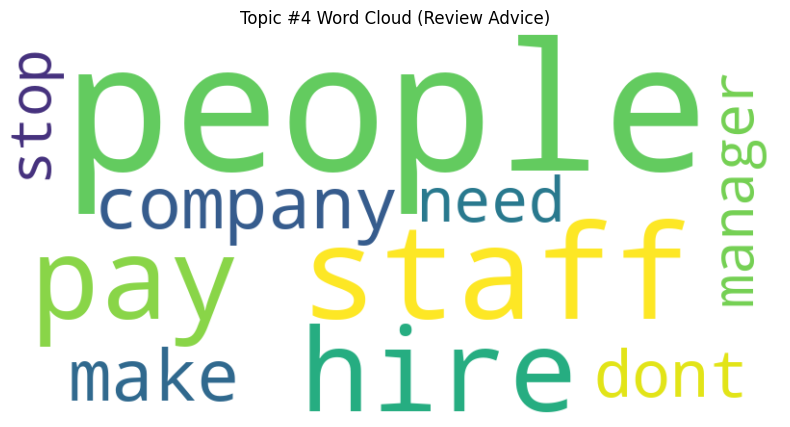

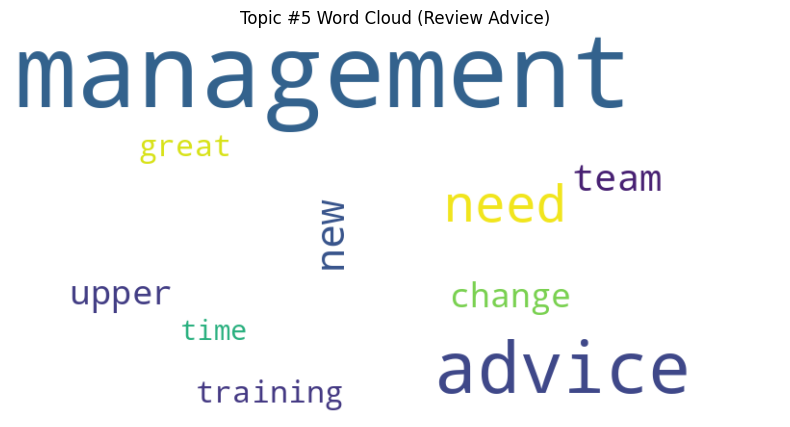

In [22]:
#Step 3: Carry out TF-IDF & NMF topic classification and visualization

# 1. Vectorize the review_advice field using the TF-IDF method
tfidf_vectorizer_advice_new = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_advice_new = tfidf_vectorizer_advice_new.fit_transform(augmented_reviews_df['review_advice'].fillna(''))

# 2. Apply NMF topic model for classification
nmf_model_advice_new = NMF(n_components=5, random_state=42)
nmf_topics_advice_new = nmf_model_advice_new.fit_transform(tfidf_advice_new)

# Print topics and their keywords
feature_names_advice_new = tfidf_vectorizer_advice_new.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model_advice_new.components_):
    print(f"Topic #{topic_idx+1} (Review Advice):")
    print(" ".join([feature_names_advice_new[i] for i in topic.argsort()[:-10 - 1:-1]]))
    print("\n")

# 3. Visualize classification results
## 3.1. Word cloud visualization
for topic_idx, topic in enumerate(nmf_model_advice_new.components_):
    # Generate a word frequency dictionary
    freqs = {feature_names_advice_new[i]: topic[i] for i in topic.argsort()[:-10 - 1:-1]}
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(freqs)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic #{topic_idx+1} Word Cloud (Review Advice)")
    plt.show()


### 3.2.2 Interpretation of the results of the new review_advice category



1.   Topic #1: Job Satisfaction & Communication: Focuses on job satisfaction, effective communication, job stability, and the importance of salary and retention. Positive notes on the work environment and communication channels with concerns about staff turnover.
2.   Topic #2: Employee Respect & Value: Highlights respect, listening, care, and trust for employees, showing the importance of fair treatment and valuing feedback for a better work environment.
3.   Topic #3: Work-Life Balance: Emphasizes balancing work and life, good work culture, mentioning efforts to balance "great" work with personal life.
4.   Topic #4: Compensation & Management: Discusses fairness in pay, recruitment, and management, reflecting desires for fair compensation, effective management, and good employee relations.
5.   Topic #5: Management & Team Building: Covers suggestions for management, team change, training, and time management, indicating constructive views on improving management efficiency and team development.

Conclusion: The analysis, supported by GPT, reveals topics like management advice, team changes, training, and time management. It underscores employees' constructive suggestions for enhancing managerial efficiency, fostering team growth, and refining training methods. The findings align with previous ones, affirming their robustness.

#4. Topics' Correlation with Income

##4.1 Extract subject words

In [23]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

#Read Excel file
df = pd.read_csv('/content/drive/MyDrive/ipen5810_miniproject1/processed0_reviews_data.csv')

columns = ['review_pros', 'review_cons', 'review_summary', 'review_advice']

# Iterate through each column, extract the first three keywords of each row and store them in a new column
for col in columns:
    # Get the text data of the current column and replace NaN values with empty strings
    # Make sure all elements are of type string
    texts = df[col].fillna('').apply(str).values
    # Initialize TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(texts)

    # Get feature name (vocabulary)
    feature_names = vectorizer.get_feature_names_out()

    #Find the three words with the highest TF-IDF score for each document
    top_words = []
    for row in tfidf_matrix:
        # Get the index of the three words with the highest TF-IDF value of the current document
        top_indices = row.toarray()[0].argsort()[-3:][::-1]  # Sort the TF-IDF values of each row in descending order and take the index of the three largest values
        # Find the corresponding word through the index
        top_three_words = [feature_names[index] for index in top_indices]
        top_words.append(' '.join(top_three_words))  # Combine three words into one string

    # Store the three subject headings of each column in new columns
    df[f'{col}_top_3_tfidf_words'] = top_words

df.to_csv('/content/drive/MyDrive/ipen5810_miniproject1/processed1_modified_data.csv', index=False)


## 4.2 Calculate cosine similarity

In [24]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv('/content/drive/MyDrive/ipen5810_miniproject1/processed1_modified_data.csv')

# Make sure the text column does not contain null values
df = df.dropna(subset=['review_pros_top_3_tfidf_words', 'review_summary_top_3_tfidf_words', 'review_cons_top_3_tfidf_words'])

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# TF-IDF vectorize the 'review_pros_top_3_tfidf_words' and 'review_summary_top_3_tfidf_words' columns and calculate cosine similarity
combined_texts_pros_summary = df['review_pros_top_3_tfidf_words'].tolist() + df['review_summary_top_3_tfidf_words'].tolist()
tfidf_matrix_pros_summary = vectorizer.fit_transform(combined_texts_pros_summary)
tfidf_matrix_pros = tfidf_matrix_pros_summary[:len(df)]
tfidf_matrix_summary_for_pros = tfidf_matrix_pros_summary[len(df):]
cosine_similarities_pros_summary = [cosine_similarity(tfidf_matrix_pros[i], tfidf_matrix_summary_for_pros[i])[0][0] for i in range(len(df))]

# TF-IDF vectorize the 'review_cons_top_3_tfidf_words' and 'review_summary_top_3_tfidf_words' columns and calculate cosine similarity
combined_texts_cons_summary = df['review_cons_top_3_tfidf_words'].tolist() + df['review_summary_top_3_tfidf_words'].tolist()
# Using the same vectorizer may result in inconsistent feature spaces, reinitialize the vectorizer for each combination
vectorizer = TfidfVectorizer()
tfidf_matrix_cons_summary = vectorizer.fit_transform(combined_texts_cons_summary)
tfidf_matrix_cons = tfidf_matrix_cons_summary[:len(df)]
tfidf_matrix_summary_for_cons = tfidf_matrix_cons_summary[len(df):]
cosine_similarities_cons_summary = [cosine_similarity(tfidf_matrix_cons[i], tfidf_matrix_summary_for_cons[i])[0][0] for i in range(len(df))]

# Add cosine similarity results as a new column
df['Cosine Similarity (Pros vs. Summary)'] = cosine_similarities_pros_summary
df['Cosine Similarity (Cons vs. Summary)'] = cosine_similarities_cons_summary

# Add descriptive statistics about Cosine Similarity
cosine_sim_stats = df[['Cosine Similarity (Pros vs. Summary)', 'Cosine Similarity (Cons vs. Summary)']].describe()

# Save as new csv file
df.to_csv('/content/drive/MyDrive/ipen5810_miniproject1/processed2_cosine_similarity.csv', index=False)

# Descriptive statistics of Cosine Similarity
print("Cosine Similarity Description:")
print(cosine_sim_stats)

Cosine Similarity Description:
       Cosine Similarity (Pros vs. Summary)  \
count                          66104.000000   
mean                               0.048291   
std                                0.137971   
min                                0.000000   
25%                                0.000000   
50%                                0.000000   
75%                                0.000000   
max                                1.000000   

       Cosine Similarity (Cons vs. Summary)  
count                          66104.000000  
mean                               0.031572  
std                                0.105093  
min                                0.000000  
25%                                0.000000  
50%                                0.000000  
75%                                0.000000  
max                                1.000000  


##4.3 draw image

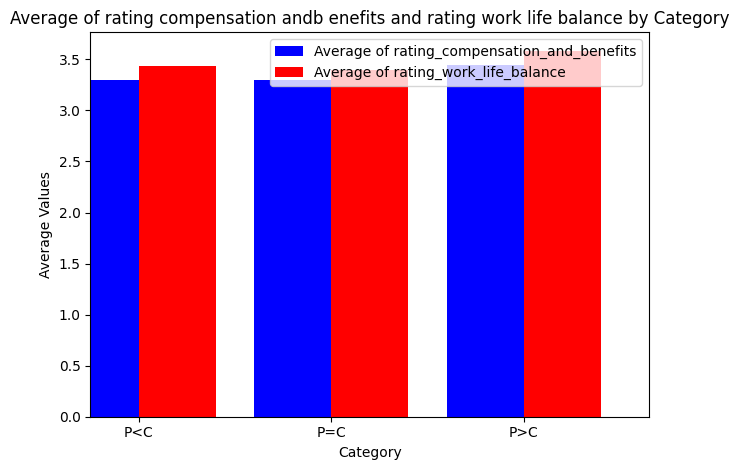

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/ipen5810_miniproject1/processed2_cosine_similarity.csv')

# Make sure the data in columns A, B, D and e are numeric for comparison and calculation
for column in ['Cosine Similarity (Pros vs. Summary)', 'Cosine Similarity (Cons vs. Summary)', 'rating_compensation_and_benefits', 'rating_work_life_balance']:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Clear any NaN values that may result from conversion
df.dropna(subset=['Cosine Similarity (Pros vs. Summary)', 'Cosine Similarity (Cons vs. Summary)', 'rating_compensation_and_benefits', 'rating_work_life_balance'], inplace=True)

# Compare the values in column A and column B and classify based on the comparison results
conditions = [
    df['Cosine Similarity (Pros vs. Summary)'] > df['Cosine Similarity (Cons vs. Summary)'],
    df['Cosine Similarity (Pros vs. Summary)'] < df['Cosine Similarity (Cons vs. Summary)'],
    df['Cosine Similarity (Pros vs. Summary)'] == df['Cosine Similarity (Cons vs. Summary)']
]
categories = ['P>C', 'P<C', 'P=C']

# Create a new column to store classification results
df['Category'] = np.select(conditions, categories, default='Unknown')

# Calculate the mean of columns D and e in each category
mean_values_d = df.groupby('Category')['rating_compensation_and_benefits'].mean()
mean_values_e = df.groupby('Category')['rating_work_life_balance'].mean()

# Draw a bar chart
fig, ax = plt.subplots()
mean_values_d.plot(kind='bar', color='blue', ax=ax, width=0.4, position=1, label='Average of rating_compensation_and_benefits')
mean_values_e.plot(kind='bar', color='red', ax=ax, width=0.4, position=0, label='Average of rating_work_life_balance')

plt.xlabel('Category')
plt.ylabel('Average Values')
plt.title('Average of rating compensation andb enefits and rating work life balance by Category')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

##4.4 Regress predictions and calculate predicted values

1
2


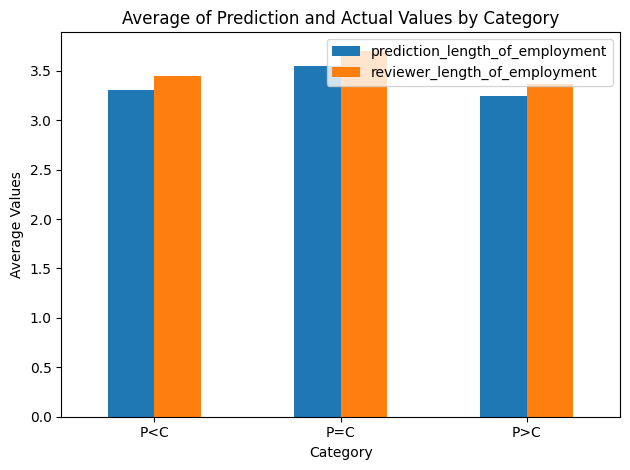

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv('/content/drive/MyDrive/ipen5810_miniproject1/processed2_cosine_similarity.csv')

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Convert integer column to string
df["review_summary"] = df["review_summary"].astype(str)
df["review_advice"] = df["review_advice"].astype(str)
df["review_pros"] = df["review_pros"].astype(str)
df["review_cons"] = df["review_cons"].astype(str)

# Concatenate text into one large string
df["all_review"] = df["review_summary"] + " " + df["review_advice"] + " " + df["review_pros"]+ " " + df["review_cons"]

# Remove samples with NaN values
df.dropna(subset=['reviewer_length_of_employment'], inplace=True)

# TF-IDF vectorization
tfidf_features = vectorizer.fit_transform(df["all_review"])

# Prepare data
X = tfidf_features
y = df["reviewer_length_of_employment"]

# Divide training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the random forest regression model
regressor = RandomForestRegressor()

print(1)
# Training model
regressor.fit(X_train, y_train)
print(2)

# Predict test set
y_pred = regressor.predict(X_test)

# Add prediction results to DataFrame
df['prediction_length_of_employment'] = regressor.predict(tfidf_features)

# Compare the mean of predicted and actual values
# Classify first
conditions = [
    df['Cosine Similarity (Pros vs. Summary)'] > df['Cosine Similarity (Cons vs. Summary)'],
    df['Cosine Similarity (Pros vs. Summary)'] < df['Cosine Similarity (Cons vs. Summary)'],
    df['Cosine Similarity (Pros vs. Summary)'] == df['Cosine Similarity (Cons vs. Summary)']
]
categories = ['P>C', 'P<C', 'P=C']
df['Category'] = np.select(conditions, categories, default='Unknown')

# Calculate mean
mean_values = df.groupby('Category')[['prediction_length_of_employment', 'reviewer_length_of_employment']].mean()

# Draw a bar chart
mean_values.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Average Values')
plt.title('Average of Prediction and Actual Values by Category')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


df.to_csv('/content/drive/MyDrive/ipen5810_miniproject1/processed3_predictions.csv', index=False)


## 4.5 Clustering

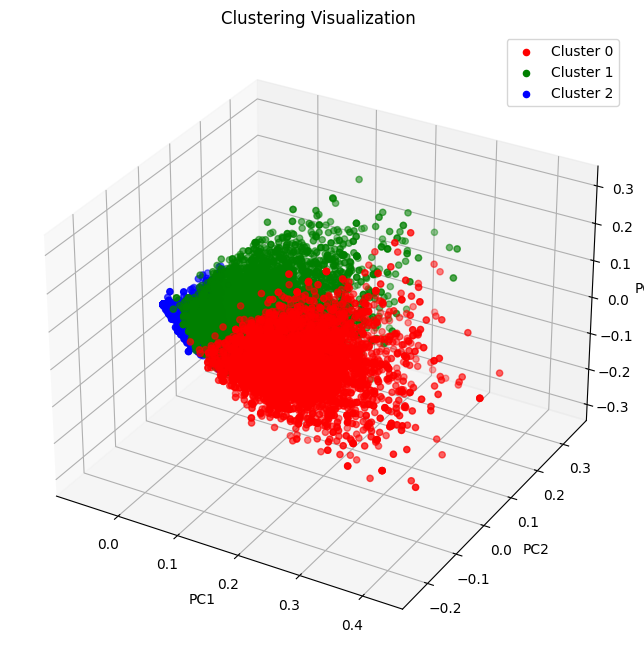

In [27]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

data = pd.read_csv('/content/drive/MyDrive/ipen5810_miniproject1/processed3_predictions.csv')


# Merge multiple columns of data into a feature vector
data['combined_features'] = data['review_advice']  + data['review_summary'] + data['review_cons']+data['review_pros']

# Fill missing values
data['combined_features'].fillna("", inplace=True)

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(data['combined_features'])

# Use K-means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, n_init=10)

kmeans.fit(tfidf_matrix)

# Use PCA to reduce the dimensionality of TF-IDF vector space to 2 or 3 dimensions
pca = PCA(n_components=3)
tfidf_matrix_2d = pca.fit_transform(tfidf_matrix.toarray())

# Visualize clustering results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define color list
colors = ['r', 'g', 'b']

# Draw a scatter plot
for cluster_label, color in zip(range(num_clusters), colors):
    cluster_data = tfidf_matrix_2d[kmeans.labels_ == cluster_label]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_label}', c=color)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Clustering Visualization')
ax.legend()
plt.show()


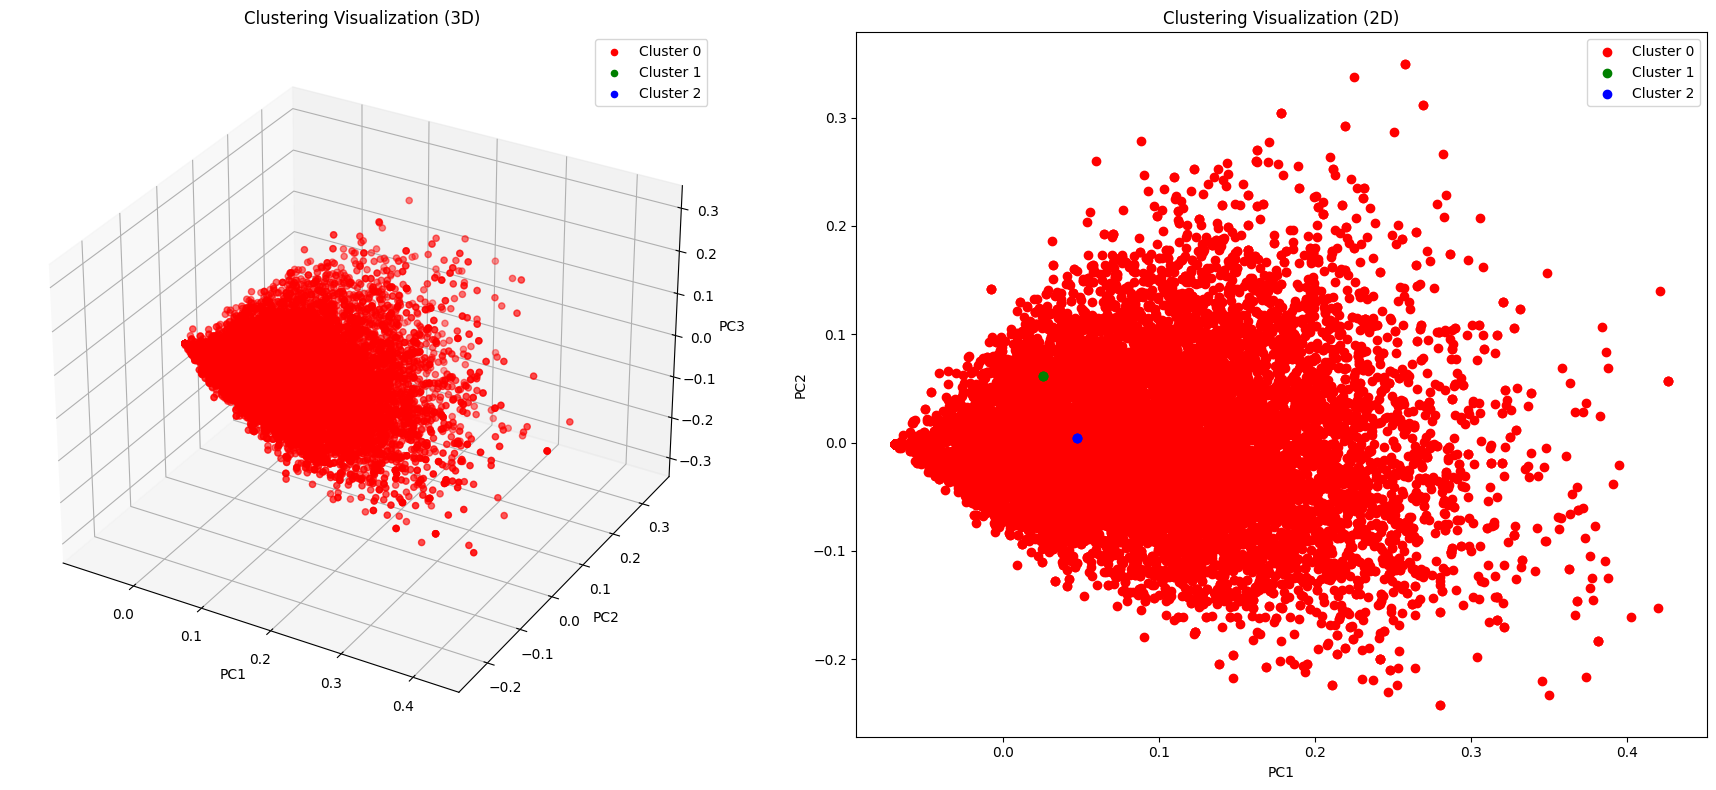

In [28]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

data = pd.read_csv('/content/drive/MyDrive/ipen5810_miniproject1/processed3_predictions.csv')

# Merge multiple columns of data into a feature vector
data['combined_features'] = data['review_advice']  + data['review_summary'] + data['review_cons'] + data['review_pros']

# Fill missing values
data['combined_features'].fillna("", inplace=True)

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(data['combined_features'])

# Use K-means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, n_init=10)
kmeans.fit(tfidf_matrix)

# Use PCA to reduce the dimensionality of TF-IDF vector space to 2 or 3 dimensions
pca = PCA(n_components=3)
tfidf_matrix_2d = pca.fit_transform(tfidf_matrix.toarray())

# Visualize clustering results
fig = plt.figure(figsize=(18, 8))

# Draw a 3D scatter plot
ax1 = fig.add_subplot(121, projection='3d')

# Define color list
colors = ['r', 'g', 'b']

# Draw a 3D scatter plot
for cluster_label, color in zip(range(num_clusters), colors):
    cluster_data = tfidf_matrix_2d[kmeans.labels_ == cluster_label]
    ax1.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_label}', c=color)

ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title('Clustering Visualization (3D)')
ax1.legend()

# Use PCA to reduce the dimensionality of TF-IDF vector space to 2 dimensions
pca_2d = PCA(n_components=2)
tfidf_matrix_2d = pca_2d.fit_transform(tfidf_matrix.toarray())

# Draw a 2D scatter plot
ax2 = fig.add_subplot(122)

# Draw a 2D scatter plot
for cluster_label, color in zip(range(num_clusters), colors):
    cluster_data_2d = tfidf_matrix_2d[kmeans.labels_ == cluster_label]
    ax2.scatter(cluster_data_2d[:, 0], cluster_data_2d[:, 1], label=f'Cluster {cluster_label}', c=color)

ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('Clustering Visualization (2D)')
ax2.legend()

plt.tight_layout()
plt.show()


#5. some facts interesting

##5.1 Descriptive statistics of classification results

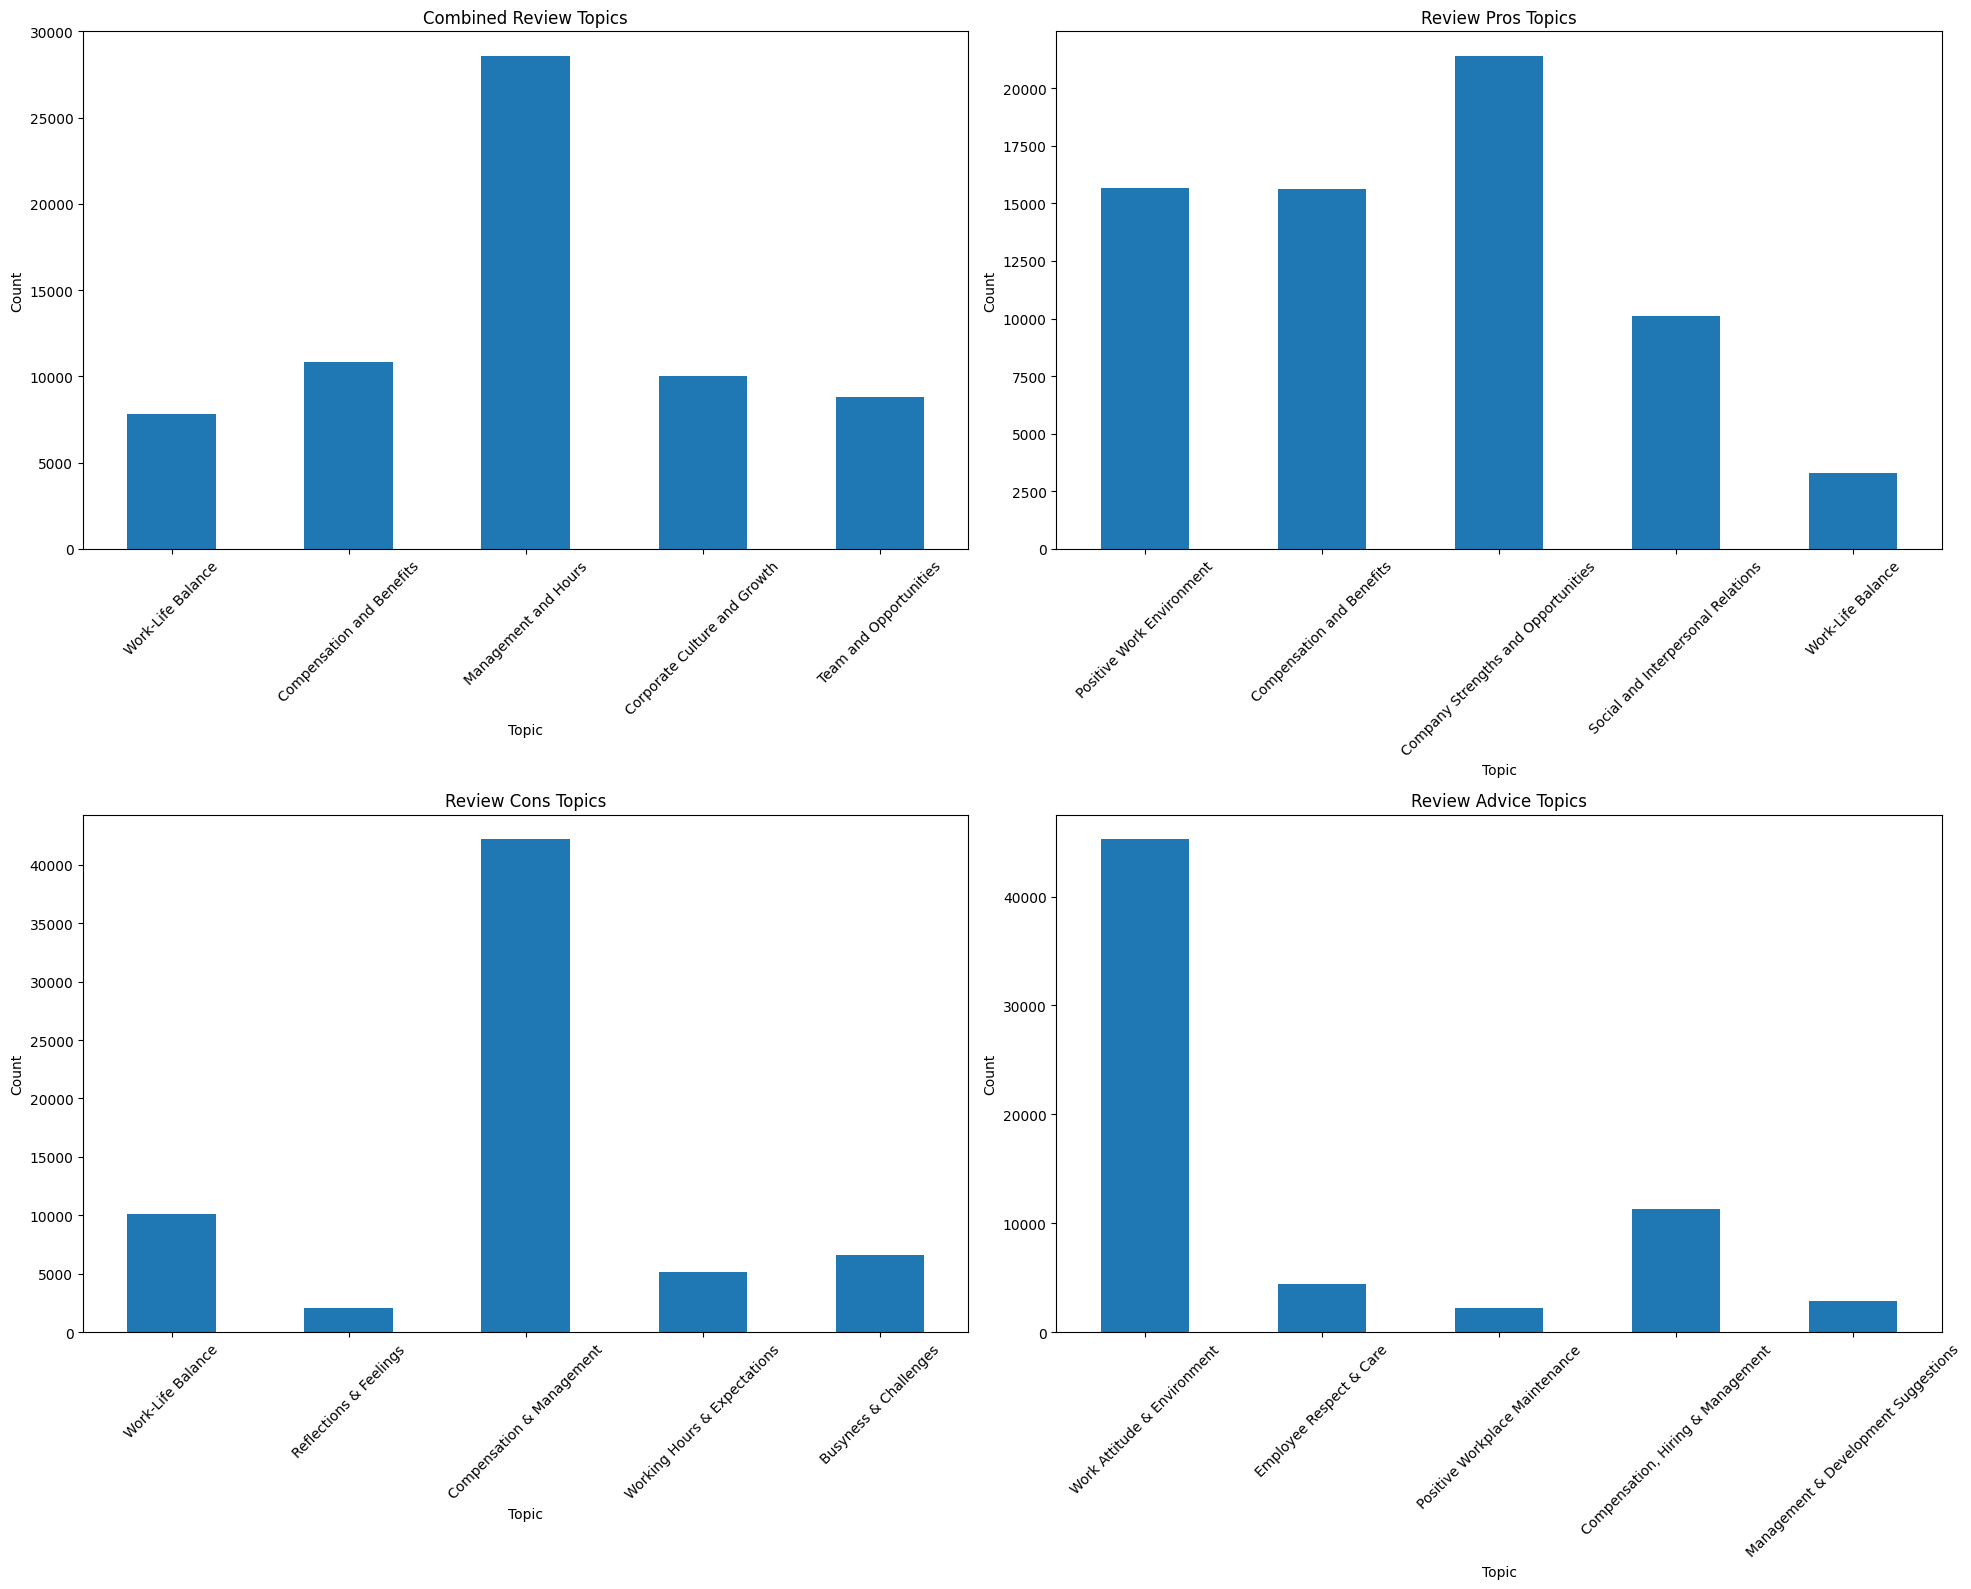

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Updating the plot code to include all categories with their respective topic names

# New topic names for each category
topic_names_combined = {
    0: 'Work-Life Balance',
    1: 'Compensation and Benefits',
    2: 'Management and Hours',
    3: 'Corporate Culture and Growth',
    4: 'Team and Opportunities'
}

topic_names_pros = {
    0: 'Positive Work Environment',
    1: 'Compensation and Benefits',
    2: 'Company Strengths and Opportunities',
    3: 'Social and Interpersonal Relations',
    4: 'Work-Life Balance'
}

topic_names_cons = {
    0: 'Work-Life Balance',
    1: 'Reflections & Feelings',
    2: 'Compensation & Management',
    3: 'Working Hours & Expectations',
    4: 'Busyness & Challenges'
}

topic_names_advice = {
    0: 'Work Attitude & Environment',
    1: 'Employee Respect & Care',
    2: 'Positive Workplace Maintenance',
    3: 'Compensation, Hiring & Management',
    4: 'Management & Development Suggestions'
}

# Plotting function
def plot_topic_distribution(data, column, topic_names, title, ax):
    counts = data[column].value_counts().sort_index()
    counts.index = [topic_names[idx] for idx in counts.index]
    counts.plot(kind='bar', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Topic')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

plot_topic_distribution(reviews_data, 'classify_combined_review', topic_names_combined, 'Combined Review Topics', axs[0, 0])
plot_topic_distribution(reviews_data, 'classify_review_pros', topic_names_pros, 'Review Pros Topics', axs[0, 1])
plot_topic_distribution(reviews_data, 'classify_review_cons', topic_names_cons, 'Review Cons Topics', axs[1, 0])
plot_topic_distribution(reviews_data, 'classify_review_advice', topic_names_advice, 'Review Advice Topics', axs[1, 1])

plt.tight_layout()
plt.show()


#4  Topics' Correlation with Income

提取主题词

##5.2 Word Cloud Analysis - Who Cares Work-Life Balance？

###5.2.1 Which countries pay more attention to work-life balance？
Analysis using combined_reviews field

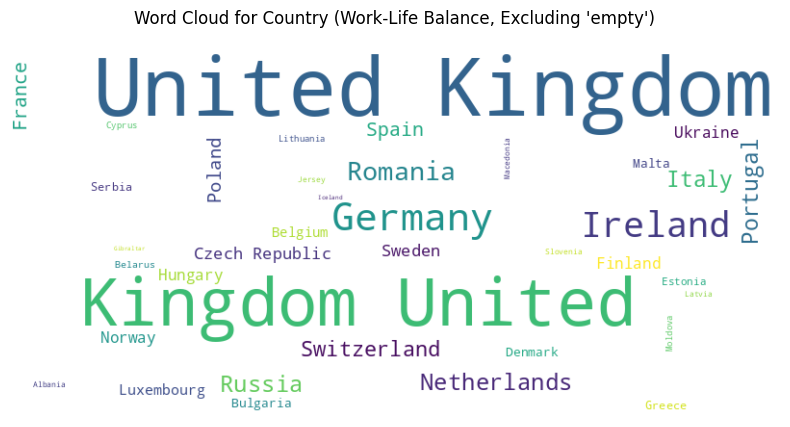

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming 'reviews_data' contains the 'country' column and it's correctly named
country_column_name = 'country'  # Replace 'country' with the actual column name if it's different

# Filtering the dataset for 'combined_review' category 0 (Work-Life Balance) excluding 'empty' countries
work_life_balance_reviews = reviews_data[reviews_data['classify_combined_review'] == 0]
work_life_balance_reviews_nonempty = work_life_balance_reviews[work_life_balance_reviews[country_column_name] != 'empty']

def generate_word_cloud(text_series, title):
    text = " ".join(str(review) for review in text_series)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate word cloud for 'country' column excluding 'empty' values
generate_word_cloud(work_life_balance_reviews_nonempty[country_column_name], 'Word Cloud for Country (Work-Life Balance, Excluding \'empty\')')


###5.2.2 Which job_categories focus on work-life balance？

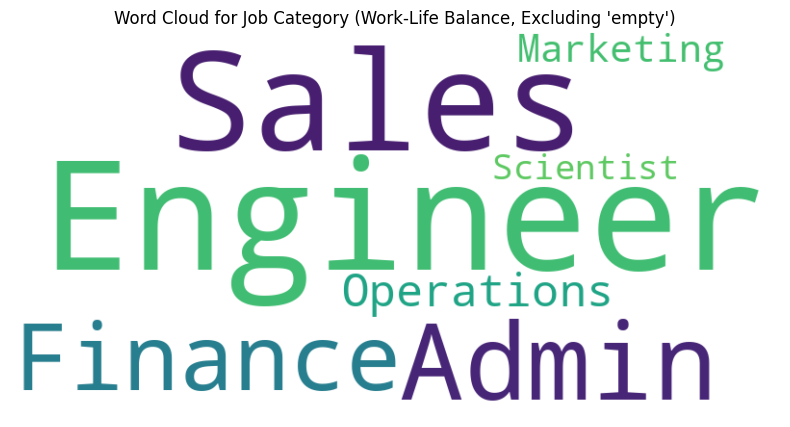

In [31]:
# Assuming 'reviews_data' contains a column for job categories correctly named
job_category_column_name = 'job_category'  # Replace 'job_category' with the actual column name if it's different

# Filter dataset for Work-Life Balance (category 0) excluding 'empty' job categories
work_life_balance_reviews_nonempty_job = work_life_balance_reviews[work_life_balance_reviews[job_category_column_name] != 'empty']

def generate_word_cloud(text_series, title):
    text = " ".join(str(review) for review in text_series)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate word cloud for job categories excluding 'empty' values
generate_word_cloud(work_life_balance_reviews_nonempty_job[job_category_column_name], 'Word Cloud for Job Category (Work-Life Balance, Excluding \'empty\')')


###5.2.3 Which job_title_raw focus on work-life balance？

##5.3 Sentiment Analysis & Outlier Detection - Which countries/occupations do the extremely positive and extremely negative evaluations come from?

###5.3.1 Extremely negative job_category

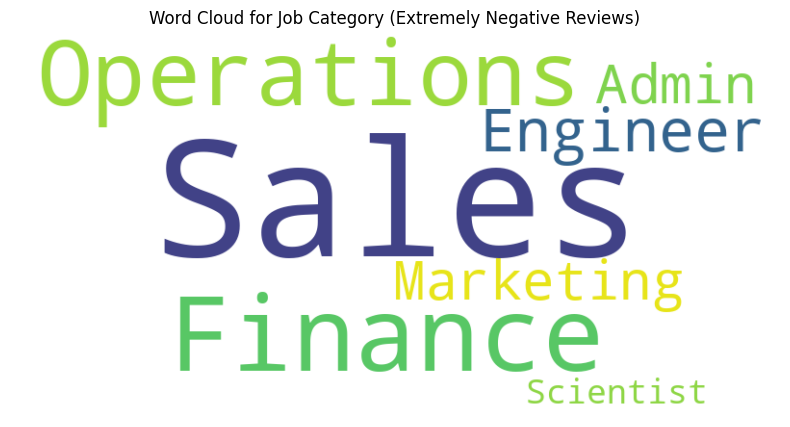

In [32]:
from textblob import TextBlob

# The name of the column containing the review text
text_column_name = 'combined_reviews'  # Update this to the actual column name

# Calculate sentiment polarity and subjectivity for each review
reviews_data['sentiment_polarity'] = reviews_data[text_column_name].apply(lambda x: TextBlob(x).sentiment.polarity)
reviews_data['sentiment_subjectivity'] = reviews_data[text_column_name].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# # Find extremely negative comments
extremely_negative_reviews = reviews_data[reviews_data['sentiment_polarity'] < -0.8]

# Generate word cloud distribution of job_category
extremely_negative_reviews_nonempty_job = extremely_negative_reviews[extremely_negative_reviews['job_category'] != 'empty']

# Generate word cloud
generate_word_cloud(extremely_negative_reviews_nonempty_job['job_category'], 'Word Cloud for Job Category (Extremely Negative Reviews)')

###5.3.2 Extremely positive job_category

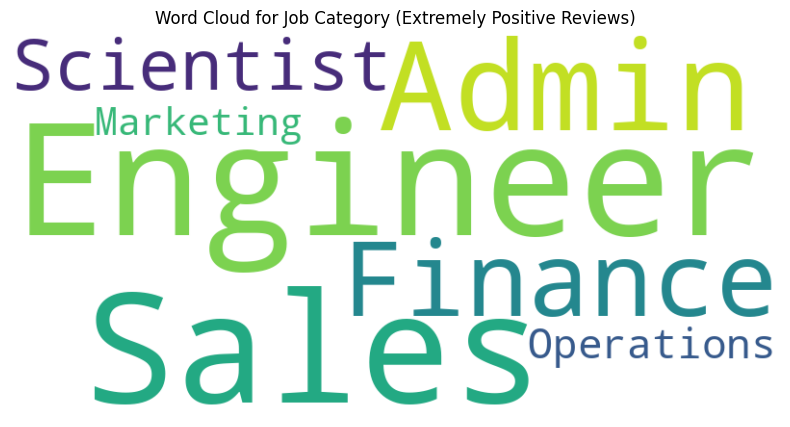

In [33]:
# Define extremely positive comments as sentiment polarity scores greater than 0.8
extremely_positive_reviews = reviews_data[reviews_data['sentiment_polarity'] > 0.8]

# Exclude rows where 'job_category' is 'empty'
extremely_positive_reviews_filtered = extremely_positive_reviews[extremely_positive_reviews['job_category'] != 'empty']

# Generate word cloud of 'job_category'
text_positive = " ".join(job for job in extremely_positive_reviews_filtered['job_category'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(text_positive)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Job Category (Extremely Positive Reviews)")
plt.show()

###5.3.3 Extremely Negative Countries

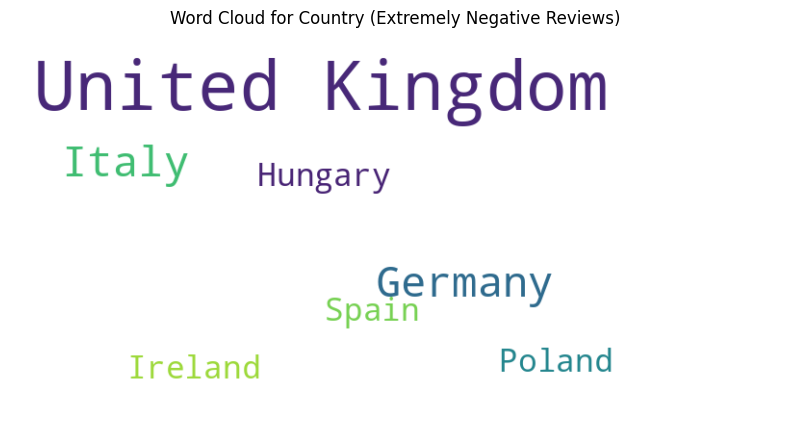

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter out extremely negative comments
extremely_negative_reviews = reviews_data[reviews_data['sentiment_polarity'] < -0.7]

# Exclude comments whose country information is 'empty'
extremely_negative_reviews_nonempty = extremely_negative_reviews[extremely_negative_reviews['country'] != 'empty']

# Generate a word cloud for the countries of these comments
text = ' '.join(country for country in extremely_negative_reviews_nonempty['country'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Country (Extremely Negative Reviews)')
plt.show()


###5.3.4 Extremely Positive Countries

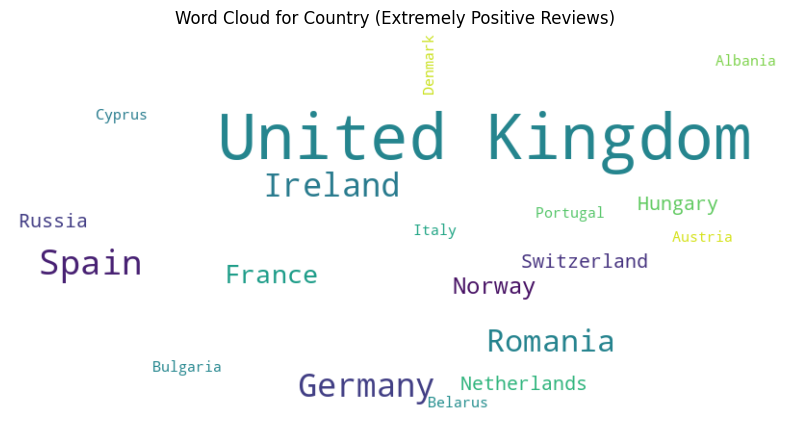

In [35]:
# Filter out extremely positive comments
extremely_positive_reviews_country = reviews_data[reviews_data['sentiment_polarity'] > 0.8]

# Exclude rows where 'country' is 'empty'
extremely_positive_reviews_country_filtered = extremely_positive_reviews_country[extremely_positive_reviews_country['country'] != 'empty']

# Generate a word cloud of 'country'
text_country_positive = " ".join(country for country in extremely_positive_reviews_country_filtered['country'])
wordcloud_country_positive = WordCloud(width=800, height=400, background_color='white').generate(text_country_positive)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_country_positive, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Country (Extremely Positive Reviews)")
plt.show()